# Causal Forest Preperation and Implementation using econml

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    ParameterGrid,
)
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from econml.dml import CausalForestDML
from scipy import stats
from linearmodels.panel import PanelOLS
import textwrap
import shap

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
os.chdir(project_root)

print(f"Working directory: {os.getcwd()}")
if not str(project_root).endswith("ml-final-project"):
    raise ValueError(
        f"Project root should be ml-final-project, but got {project_root}"
    )


randomState = 18

# plt.switch_backend('pgf') # change to 'pgf' for LaTeX export # use inline for Jupyter Notebook
# %matplotlib inline 

plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

CB_color_cycle = [ 
    '#56B4E9', '#CC79A7', '#D55E00', 
    '#009E73', '#984ea3', '#999999', 
    '#e41a1c', '#dede00']

In [69]:
subset_master = pd.read_csv('data/posteda/subset_final.csv', header=0)
subset = subset_master.copy()

W = subset[['State', 'Announcement_Year', 'Announcement_Quarter']]
subset = subset.drop(['State', 'Announcement_Year', 'Announcement_Quarter'], axis=1)

In [70]:
# get categorical columns of subset
cat_cols = subset.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('CD119_2024_Name')
cat_cols.remove('Announcement_Date')
print(cat_cols)

['Segment', 'Technology', 'Subcategory', 'Decarb_Sector', 'Project_Type', 'US Senator 1: Party', 'US Senator 2: Party', 'US Representative Party']


In [71]:
# possibly overwrite
cat_cols = subset[[
    'Segment', 
    'Technology', 
    'Subcategory', 
    'Decarb_Sector', 
    'Project_Type', 
    'US Senator 1: Party', 
    'US Senator 2: Party', 
    'US Representative Party', 
    ]].columns

In [72]:
# Get indicator variables
for col in cat_cols:
    dummies = pd.get_dummies(subset[col], prefix=col)
    subset = pd.concat([subset, dummies], axis=1)
subset = subset.drop(cat_cols, axis=1)

# Get indicator variables for FE matrix
W_columns = W.columns.tolist()
for col in W.columns:
    dummies = pd.get_dummies(W[col], prefix=col)
    W = pd.concat([W, dummies], axis=1)
W = W.drop(W_columns, axis=1)

In [73]:
# log transform CAPEX column
subset['log_Estimated_Total_Facility_CAPEX'] = np.log(subset['Estimated_Total_Facility_CAPEX'] + 1)
subset = subset.drop('Estimated_Total_Facility_CAPEX', axis=1)

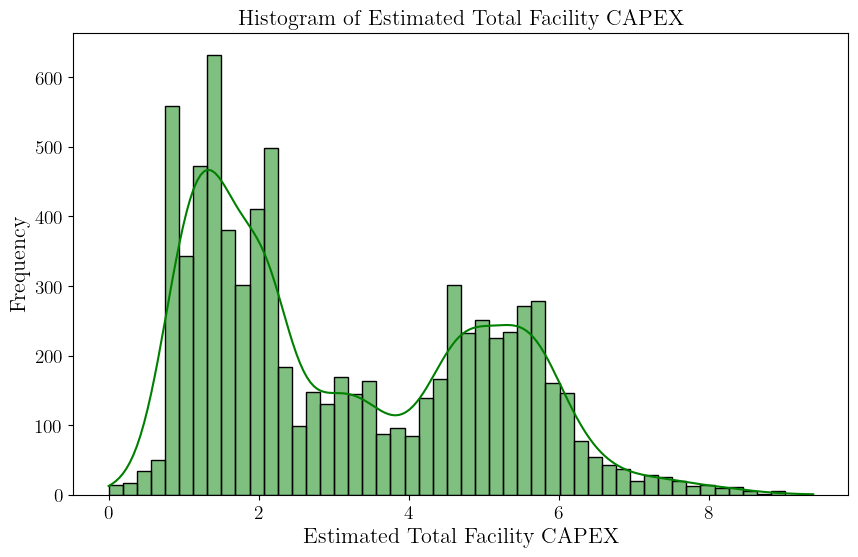

In [74]:
plt.figure(figsize=(10, 6)) # already in other figure (A.1)
sns.histplot(subset['log_Estimated_Total_Facility_CAPEX'], bins=50, kde=True, color='green')
plt.title('Histogram of Estimated Total Facility CAPEX')
plt.xlabel('Estimated Total Facility CAPEX')
plt.ylabel('Frequency')
plt.show()

In [75]:
SELECT = ['solar_irradiance', 
          'wind_speed_2m', 
          'wind_speed_2m_max', 
          'wind_speed_50m', 
          'air_temp_2m', 
          'air_temp_2m_max', 
          'air_temp_2m_min', 
          'precipitation']

Y = subset['log_Estimated_Total_Facility_CAPEX']
X = subset.drop([
    'log_Estimated_Total_Facility_CAPEX', 
    'Announcement_Date', 
    'Latitude', 
    'Longitude', 
    'US Representative Party_Democratic', # 99% collinear with T
    'US Representative Party_Republican', 
    'US Senator 1: Party_Democratic', # to much collinearity
    'US Senator 1: Party_Republican', # to much collinearity
    'US Senator 2: Party_Democratic', # to much collinearity
    'US Senator 2: Party_Republican', # to much collinearity
    ], axis=1)
T = subset['US Representative Party_Republican'] # run with democrat and republican

mask_1 = ~Y.isna()
Y = Y[mask_1]
X = X[mask_1]
T = T[mask_1]
W = W[mask_1]
mask_2 = ~X[SELECT].isna().any(axis=1)
Y = Y[mask_2]
X = X[mask_2]
T = T[mask_2]
W = W[mask_2]

# get clusters for later
clusters = X['CD119_2024_Name'].values
X = X.drop('CD119_2024_Name', axis=1)

Propensity‐score histogram & trimming: makes assumption 2 of CF explicit, avoids overtrimming

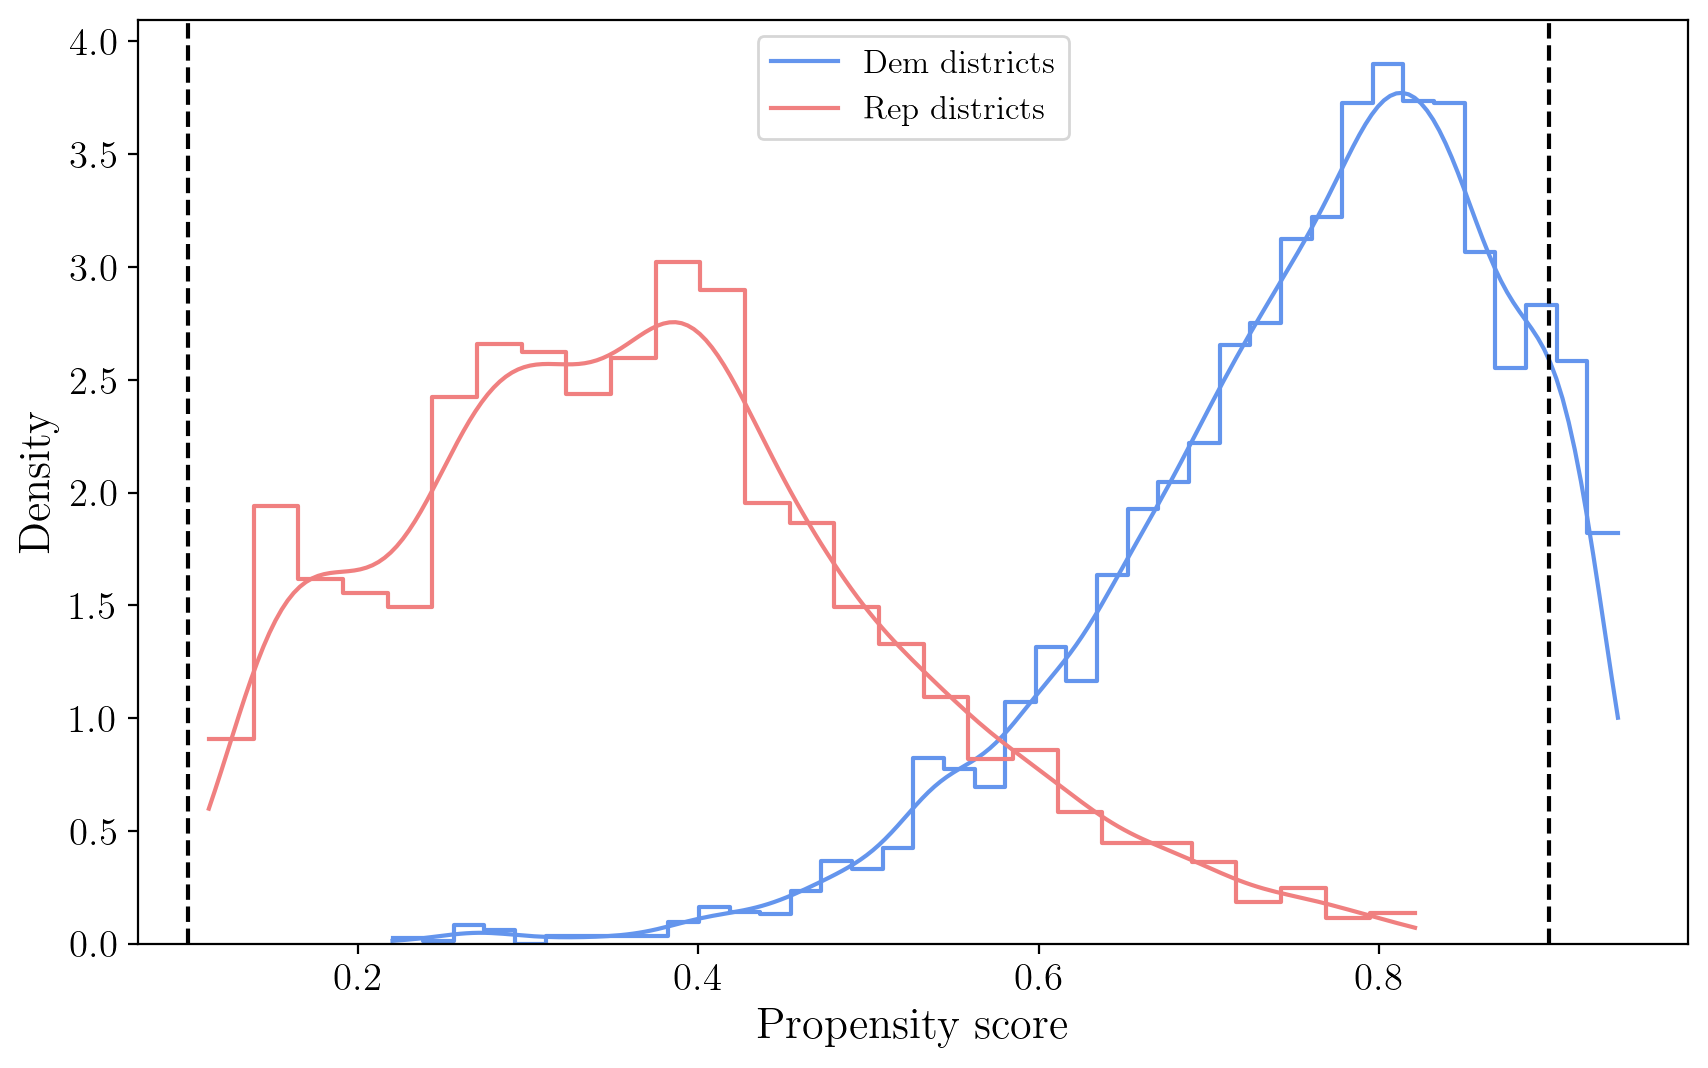

421 observations trimmed for lack of overlap
421 of 7793 obs (5.4%) outside [0.10,0.90]


In [76]:
# Overlap must be checked before CF is fit, 
# oherwise we risk training on observations that require extrapolation

ft = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=10,
        random_state=18,
    )

# Predicted probabilities of every observation
skf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
p_hat = cross_val_predict(ft, X, T, cv=skf, method="predict_proba")[:, 1] 

# gives nearly unbiased propensity estimates for the overlap plot 
# and trimming rule without leaking the test fold into the training folds

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
sns.histplot(p_hat[T==1], color="cornflowerblue", label="Dem districts",
             stat="density", kde=True, element="step", fill=False)
sns.histplot(p_hat[T==0], color="lightcoral",  label="Rep districts",
             stat="density", kde=True, element="step", fill=False)
plt.axvline(0.10, ls="--", c="k")
plt.axvline(0.90, ls="--", c="k")
# plt.title("Propensity-score overlap check")
plt.xlabel("Propensity score")
plt.legend()
plt.savefig('figures/Methods/overlap_check.png', dpi=200, bbox_inches='tight')
plt.show()

# Trim observations with p_hat < 0.10 or p_hat > 0.90 to reduce bias
mask_trim = (p_hat > 0.1) & (p_hat < 0.90)
print(f"{(~mask_trim).sum()} observations trimmed for lack of overlap")

X_trim = X[mask_trim].reset_index(drop=True)
Y_trim = Y[mask_trim].reset_index(drop=True)
T_trim = T[mask_trim].reset_index(drop=True)
W_trim = W[mask_trim].reset_index(drop=True)
clusters_trim = clusters[mask_trim]

ft.fit(X, T) # for later
trimmed = (~mask_trim).sum()
print(f"{trimmed} of {len(T)} obs ({trimmed/len(T)*100:.1f}%) outside [0.10,0.90]") # Note: 5 percent trimmed

In [77]:
# check NaN values in numeric columns
num_cols = X.select_dtypes(include=[np.number]).columns
X_num = X[num_cols]
X[num_cols].isna().sum()

solar_irradiance        0
wind_speed_2m           0
wind_speed_2m_max       0
wind_speed_50m          0
air_temp_2m             0
air_temp_2m_max         0
air_temp_2m_min         0
precipitation           0
med_household_income    0
unemployed              0
total_pop               0
gini                    0
dtype: int64

In [78]:
X_const = sm.add_constant(X_num)
vif_data = pd.DataFrame({
    "Feature":  X_const.columns,
    "VIF":      [variance_inflation_factor(X_const.values, i)
                 for i in range(X_const.shape[1])]
})
print(vif_data)

                 Feature          VIF
0                  const  1160.794483
1       solar_irradiance     9.960174
2          wind_speed_2m   190.387090
3      wind_speed_2m_max   130.926583
4         wind_speed_50m    14.475333
5            air_temp_2m  1636.339081
6        air_temp_2m_max   406.966752
7        air_temp_2m_min   527.885927
8          precipitation     3.758539
9   med_household_income     1.402433
10            unemployed     1.477196
11             total_pop     1.261871
12                  gini     1.332388


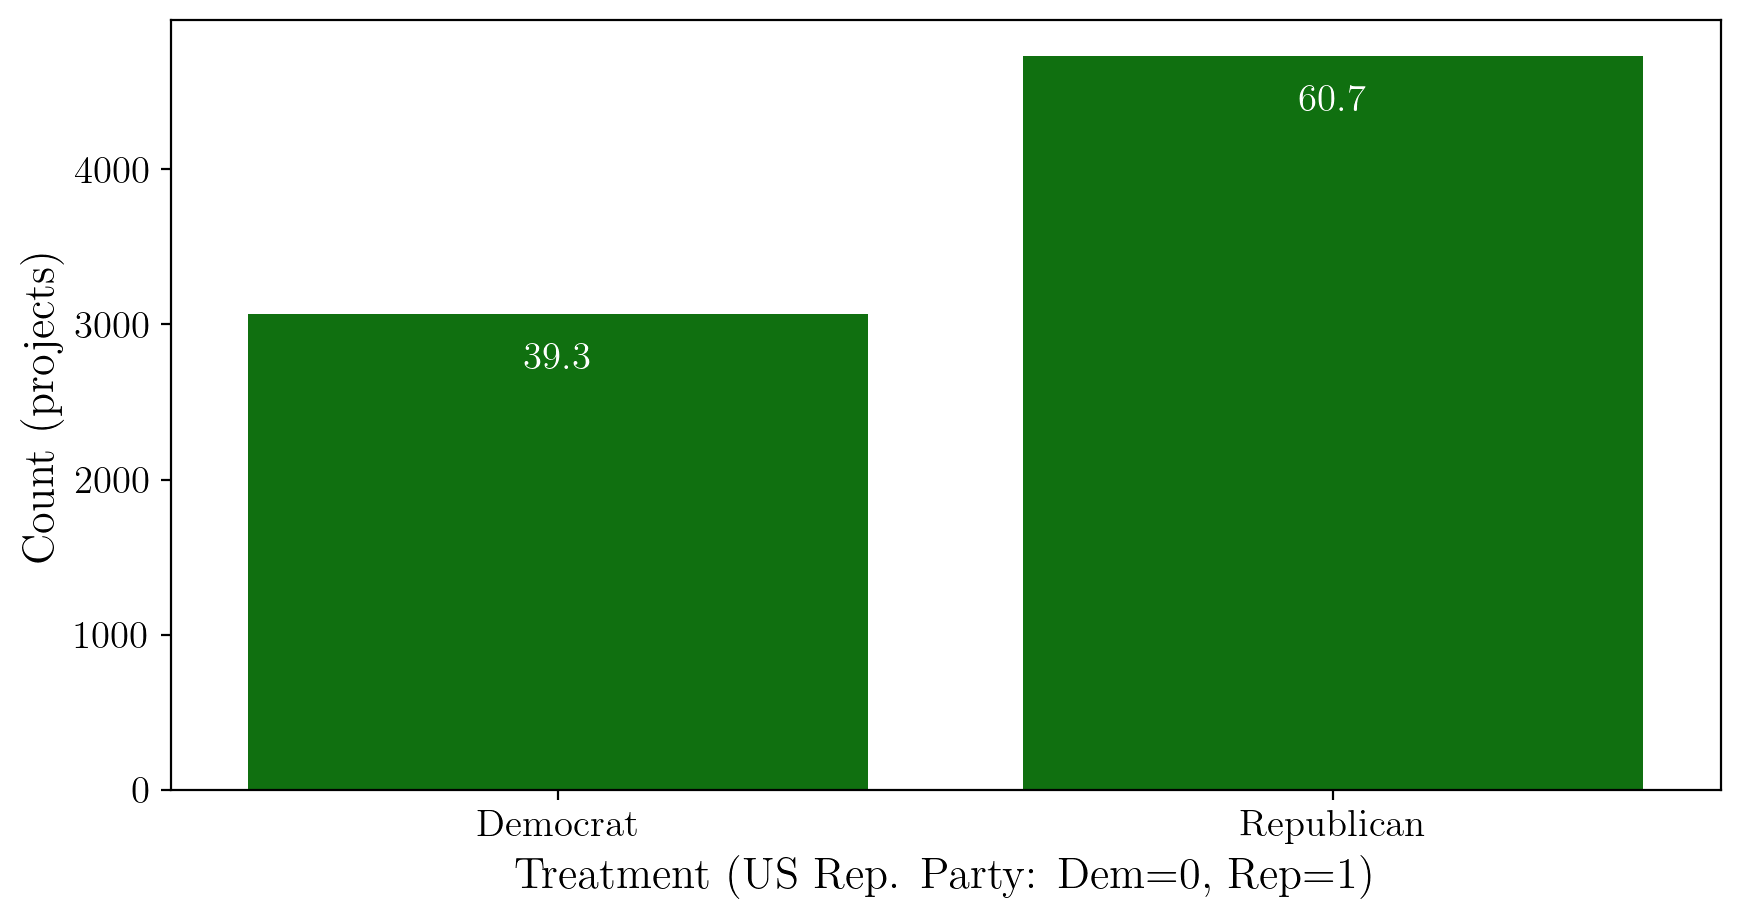

In [79]:
# Distribution of T
plt.figure(figsize=(10,5), dpi=200)
sns.countplot(x=T, color='green')
plt.xlabel("Treatment (US Rep. Party: Dem=0, Rep=1)")
plt.ylabel("Count (projects)")
plt.xticks([0, 1], ['Democrat', 'Republican'])
# plt.title("Distribution of Treatment (U.S. Rep. Party)")
total = len(T)
for i in range(2):
    percentage = (T == i).sum() / total * 100
    plt.text(i, (T == i).sum() - 400, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=14, color='white')
plt.savefig('figures/Methods/treatment_distribution.png', dpi=200)
plt.show()

In [80]:
# Summary stats: Table A.1
statistics = subset_master[mask_1]
statistics = statistics[mask_2]
statistics = statistics[mask_trim]

statistics = statistics.drop(['Latitude', 'Longitude'], axis=1)
unique_cd = statistics['CD119_2024_Name'].nunique()
print(f"Number of unique CD119_2024_Name: {unique_cd}")
unique_states = statistics['State'].nunique()
print(f"Number of unique states: {unique_states}")

summary_stats = statistics.describe().T
summary_stats = summary_stats[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
summary_stats = summary_stats.round(2)
summary_stats

Number of unique CD119_2024_Name: 396
Number of unique states: 44


mean       std        min         max  \
Estimated_Total_Facility_CAPEX     136.60    439.09       0.00    11951.80   
Announcement_Year                 2020.89      2.23    2013.00     2024.00   
Announcement_Quarter                 2.46      1.12       1.00        4.00   
solar_irradiance                     4.49      0.69       3.47        6.08   
wind_speed_2m                        2.02      1.18       0.05        6.00   
wind_speed_2m_max                    3.21      1.76       0.24        8.33   
wind_speed_50m                       5.39      1.05       3.03        8.87   
air_temp_2m                         14.19      4.96       0.04       26.07   
air_temp_2m_max                     20.05      5.59       7.20       33.22   
air_temp_2m_min                      8.89      4.92      -6.70       25.05   
precipitation                        2.52      1.38       0.17        6.53   
med_household_income             70419.95  18496.50   34351.00   227969.50   
unemployed                       20350.13   4887.79    7432.00    50885.00   
total_pop                       748438.53  49271.47  523501.00  1038197.00   
gini                                 0.46      0.02       0.37        0.56   

                                      25%        50%        75%  
Estimated_Total_Facility_CAPEX       3.33      10.94     125.51  
Announcement_Year                 2019.00    2021.00    2023.00  
Announcement_Quarter                 1.00       2.00       3.00  
solar_irradiance                     3.92       4.30       4.98  
wind_speed_2m                        0.92       2.21       2.98  
wind_speed_2m_max                    1.36       3.77       4.65  
wind_speed_50m                       4.55       5.23       6.31  
air_temp_2m                         10.12      13.38      18.01  
air_temp_2m_max                     15.36      19.21      24.97  
air_temp_2m_min                      5.00       8.47      12.42  
precipitation                        1.27       2.69       3.45  
med_household_income             57354.00   68016.50   79860.00  
unemployed                       17110.00   19767.00   22734.00  
total_pop                       718415.00  753463.00  777093.00  
gini                                 0.44       0.46       0.47

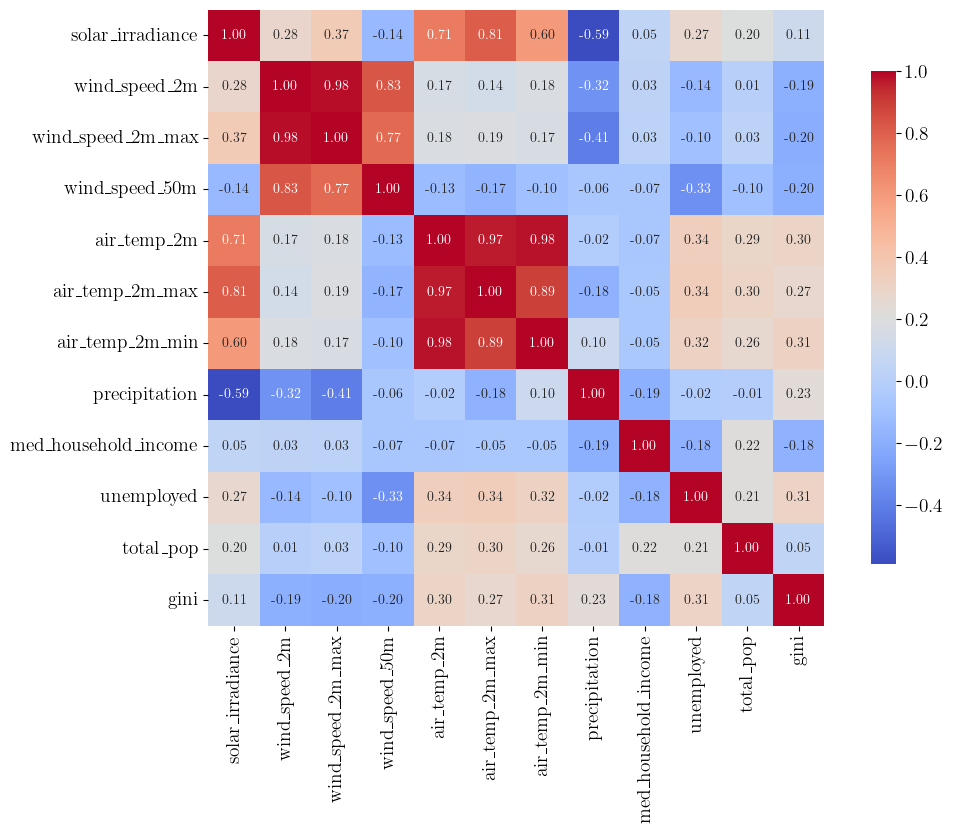

In [81]:
# Check correlation of continuous variables, not used
plt.figure(figsize=(12, 8))
sns.heatmap(X_num.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Matrix of Numeric Variables")
plt.savefig('figures/Methods/correlation_matrix_num.png', dpi=200, bbox_inches='tight')
plt.show()

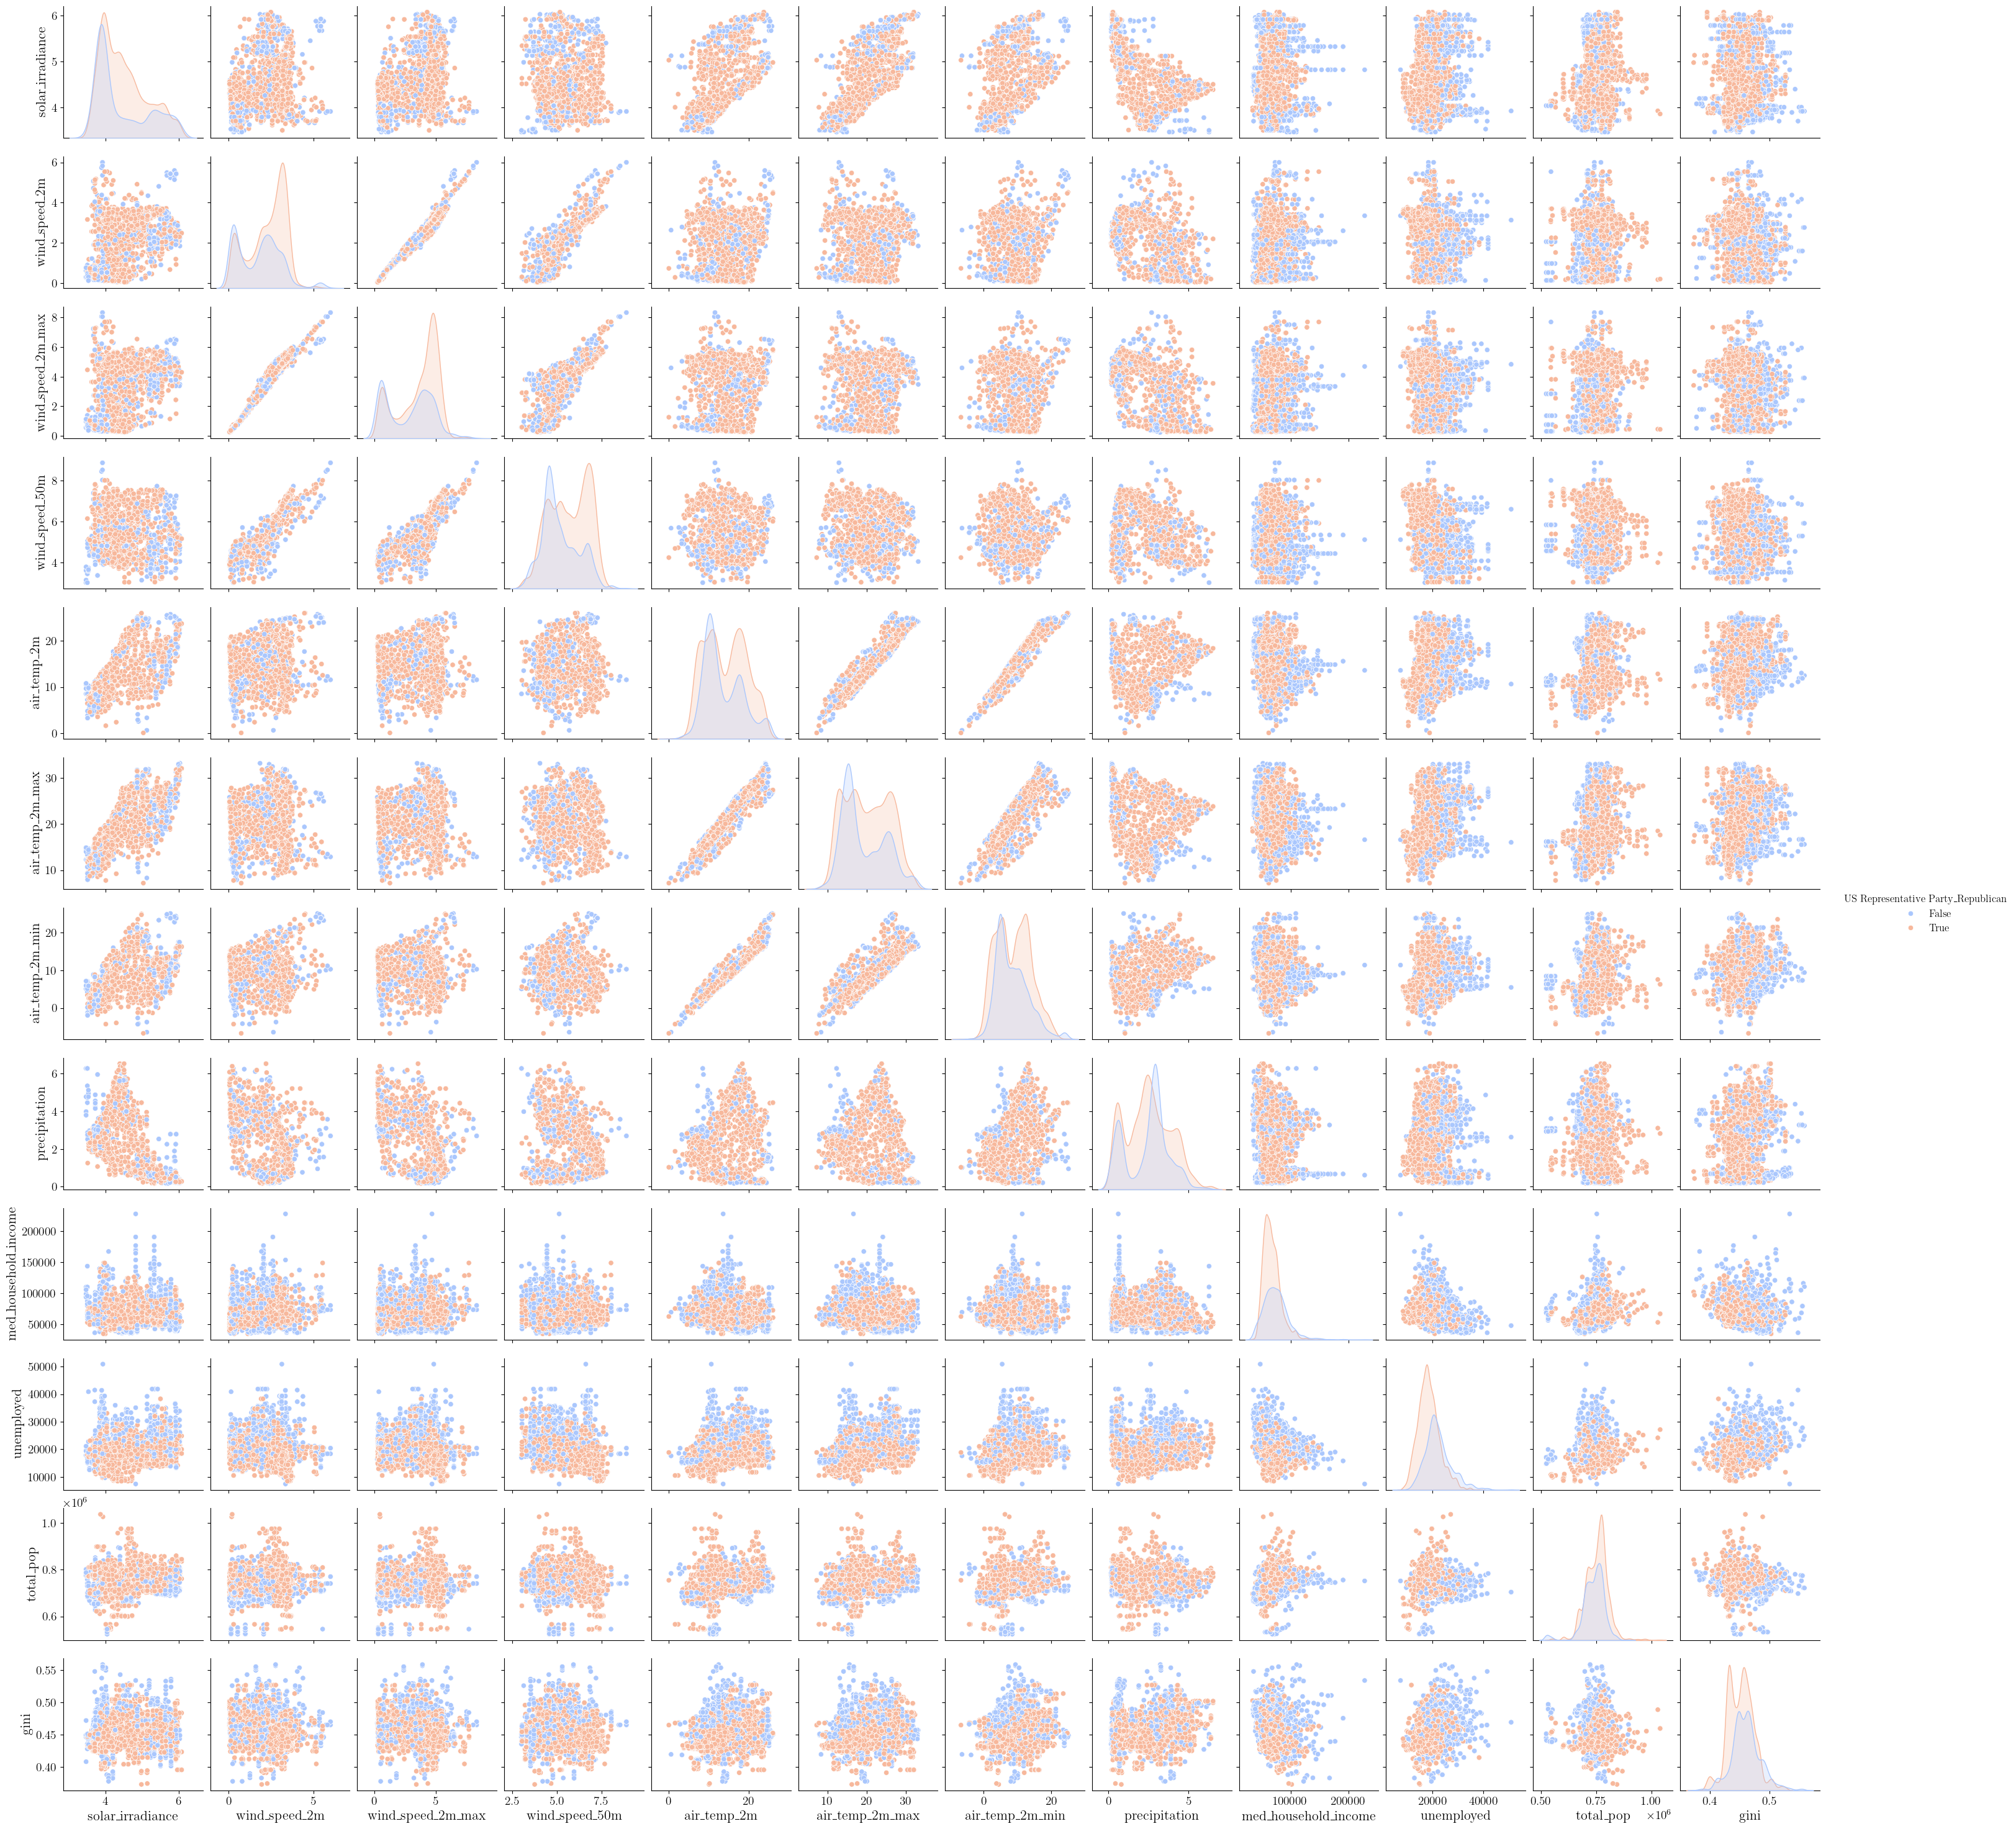

In [82]:
# Check collinearity of numeric variables, Fig. A.7
sample_cols = X_num.columns  # adjust as needed
sns.pairplot(pd.concat([X_num[sample_cols], T], axis=1), hue='US Representative Party_Republican', palette='coolwarm')
# no legend
plt.savefig('figures/Methods/pairplot_num.png', dpi=200)
plt.show()

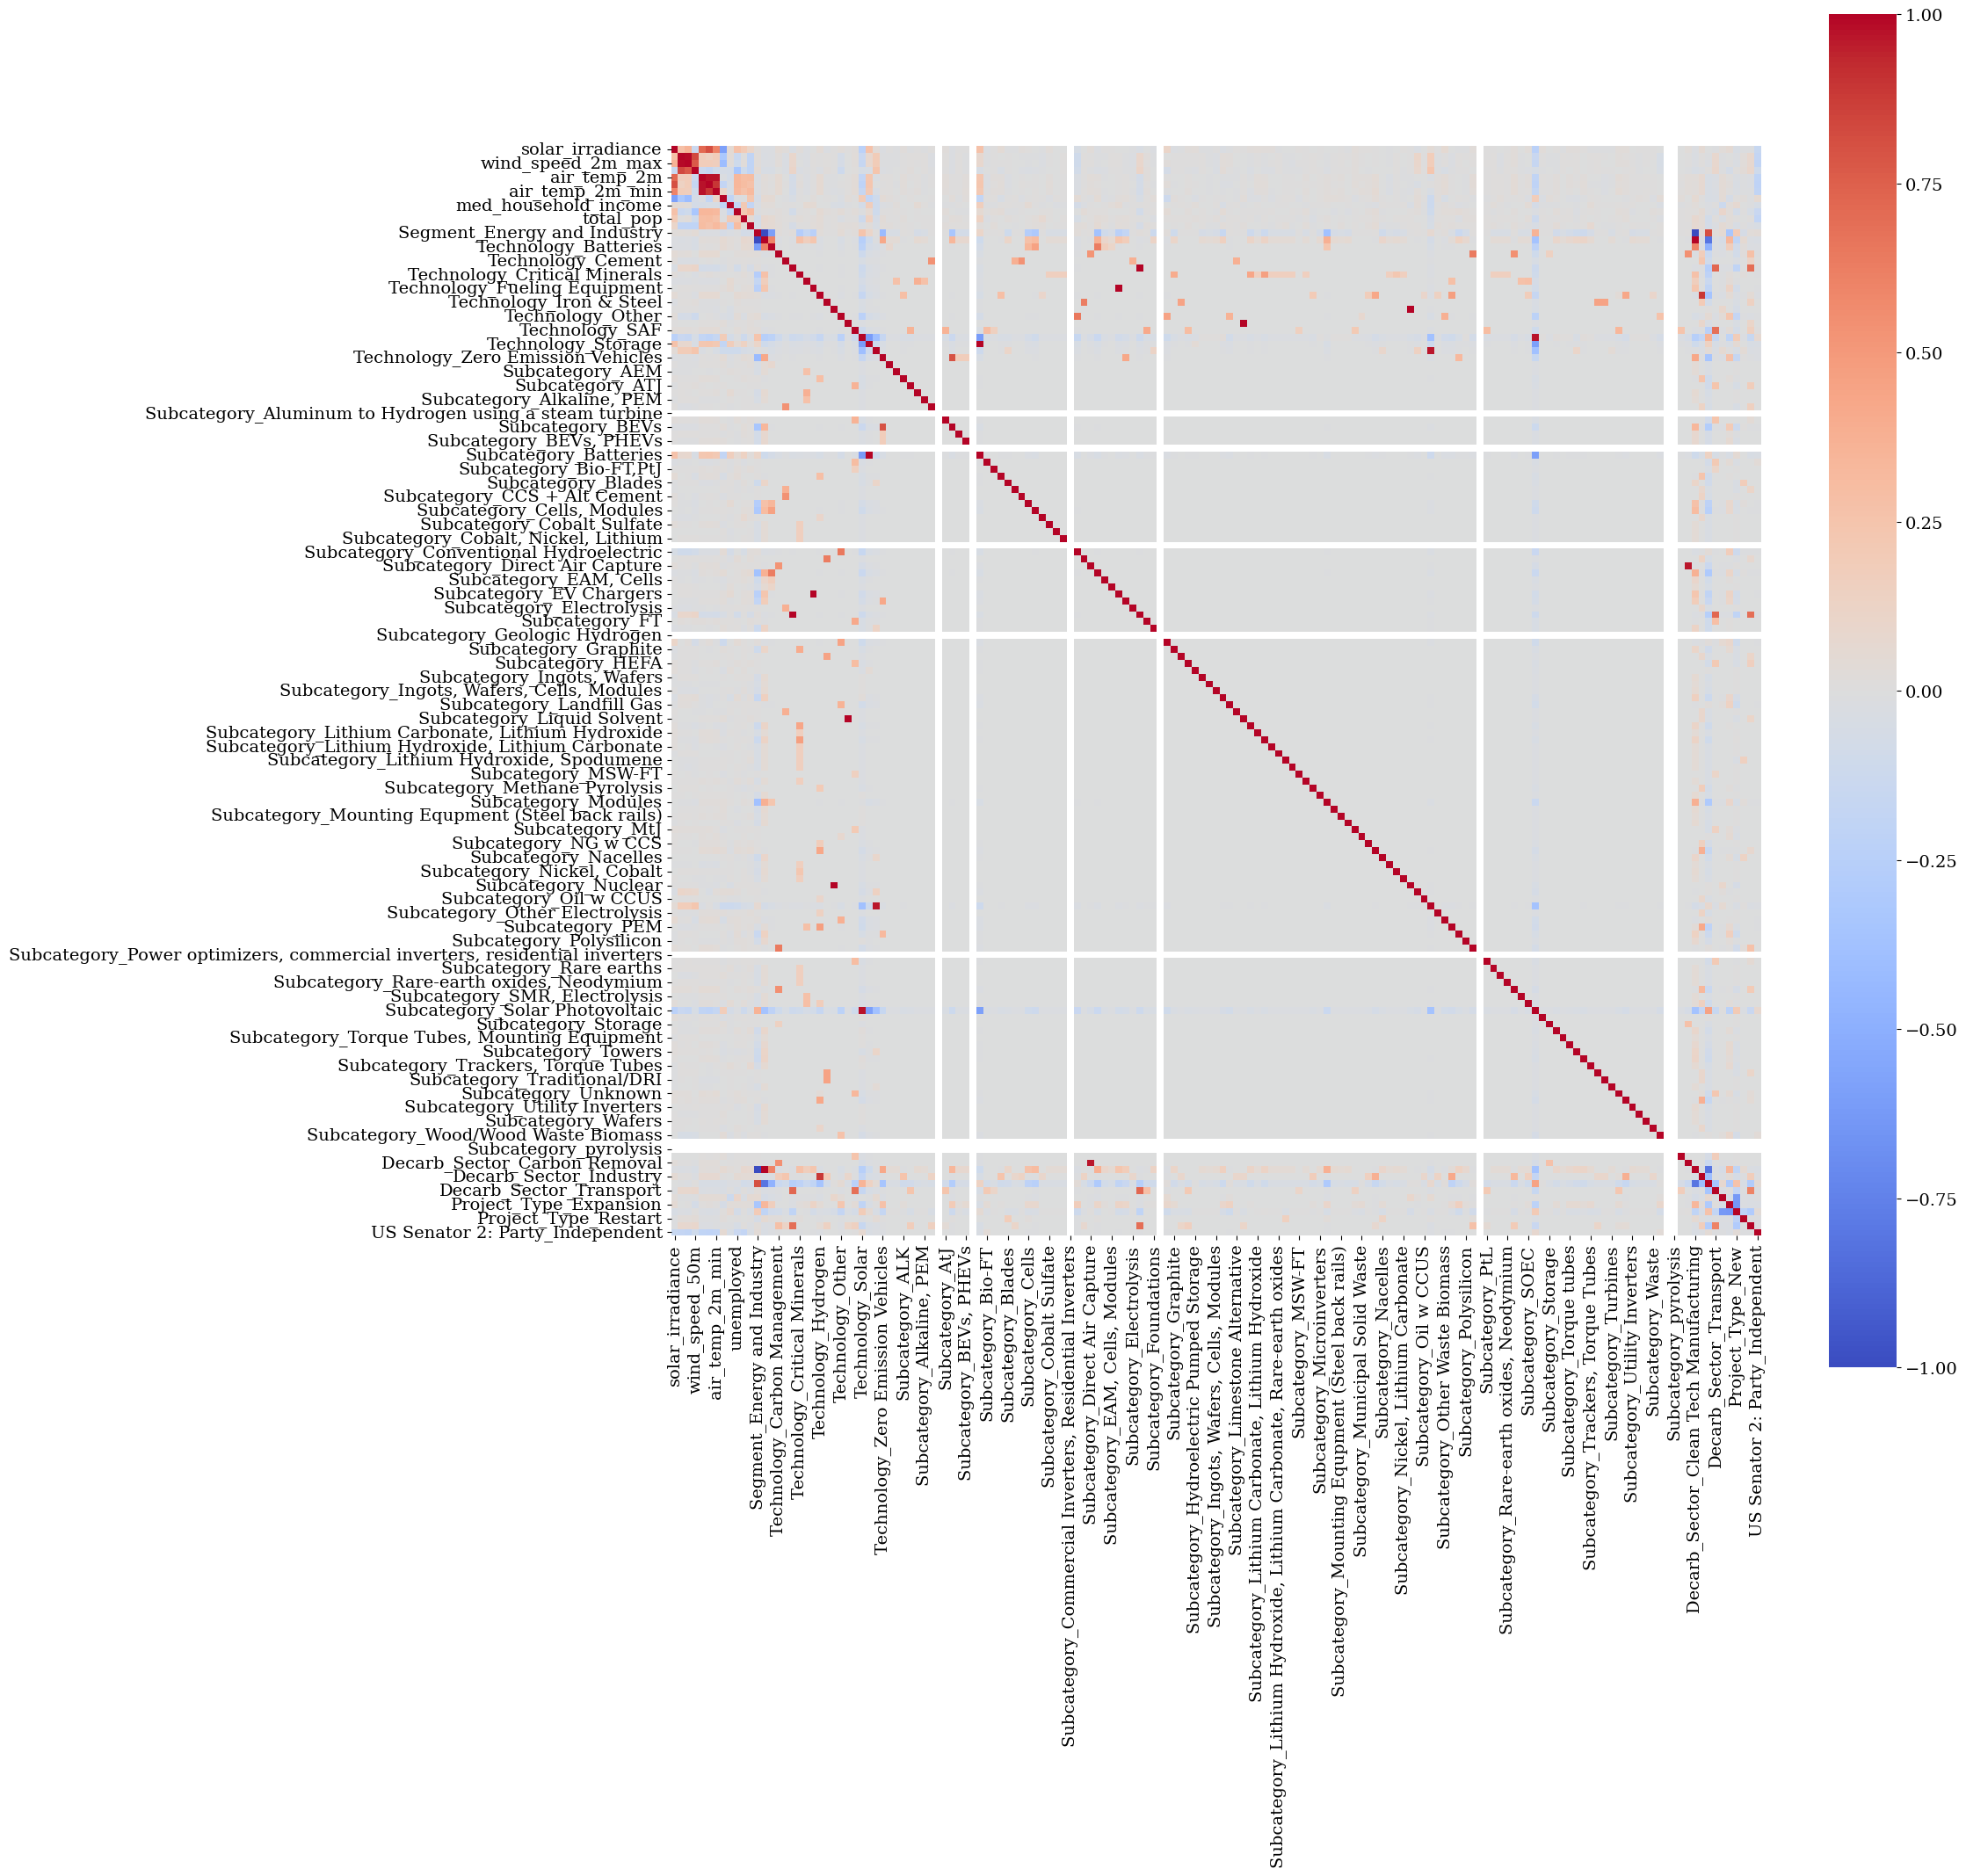

In [83]:
# correlation matrix of all of X, unused
plt.rcParams.update({"text.usetex": False})
corr = X.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='coolwarm', square=True)
# plt.title('Correlation Matrix of X')
plt.savefig('figures/Methods/correlation_matrix_X.png', dpi=200)
plt.show()
plt.rcParams.update({"text.usetex": True})

invalid value encountered in divide
invalid value encountered in divide


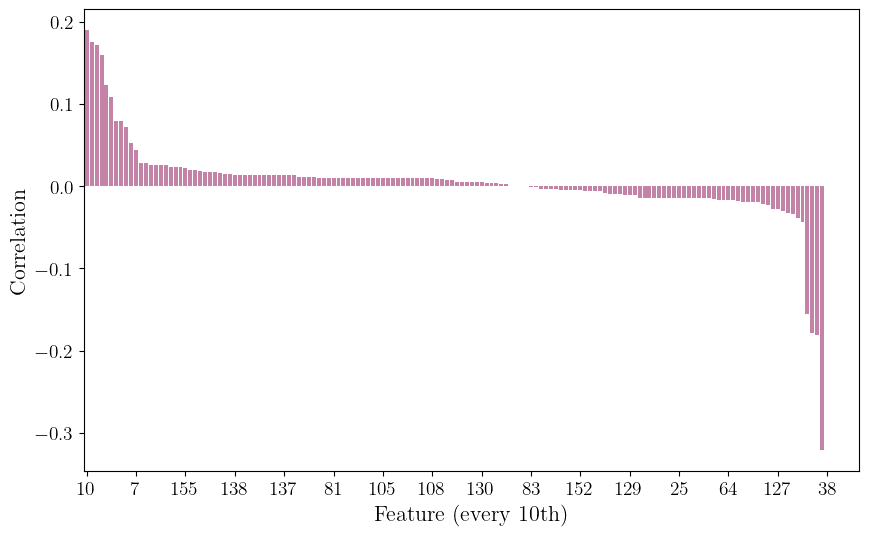

In [84]:
# compute corr(X, T) (dropped those that were collinear above), Fig. A.8
correlation_copy = X_trim.copy()
# make column names numeric
correlation_copy.columns = [f"{i}" for i in range(correlation_copy.shape[1])]

corr_X_T = correlation_copy.corrwith(T_trim)
corr_X_T = corr_X_T.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_X_T.index, y=corr_X_T.values, color=CB_color_cycle[1])
# plt.title('Correlation of X with Treatment (US Rep. Party)')
plt.xlabel('Feature (every 10th)')
plt.ylabel('Correlation')
plt.xticks(range(0, len(corr_X_T.index), 10), corr_X_T.index[::10], rotation=0)
plt.savefig('figures/Methods/correlation_X_T.png', dpi=200, bbox_inches='tight')
plt.show()

In [85]:
# Outliers
outliers = corr_X_T[abs(corr_X_T) > 0.3]
print(outliers)

9   -0.321282
dtype: float64


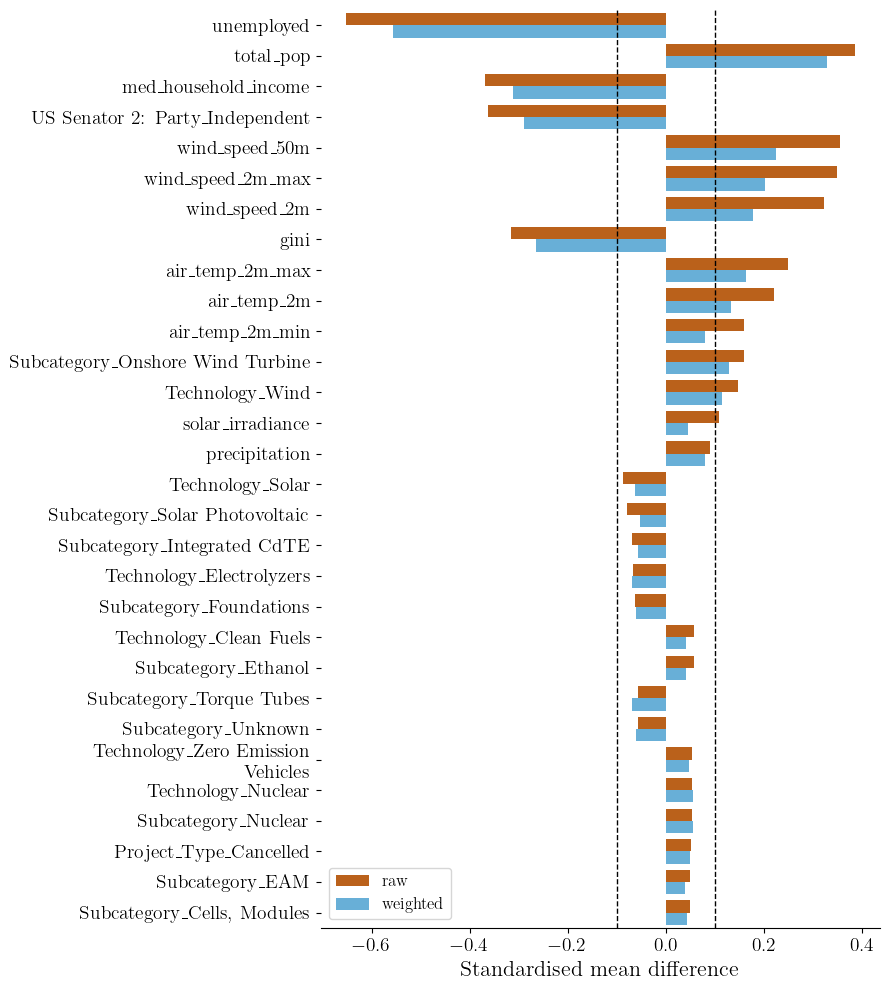

7.6% of covas still exceed |0.10| after weighting


In [86]:
# Standardised mean differences to assess balance, Fig. A.4
# (sometimes p_hat_trim already assigned)
try:
    p_hat_trim
except NameError:
    p_hat_trim = ft.predict_proba(X_trim)[:, 1] # shape (n_trim,)

w_ipw = np.where(T_trim == 1, 1 / p_hat_trim, 1 / (1 - p_hat_trim)) # IPW weights

mean_t = X_trim[T_trim == 1].mean() 
mean_c = X_trim[T_trim == 0].mean()
std_all = X_trim.std(ddof=0) # pooled stdev

smd_raw = (mean_t - mean_c) / std_all

# E[X|T=1] under IPW=Σw_i X_i / Σ w_i (within treated)
mean_t_w = (X_trim.mul(w_ipw * (T_trim == 1), axis=0).sum()
           / w_ipw[T_trim == 1].sum())

mean_c_w = (X_trim.mul(w_ipw * (T_trim == 0), axis=0).sum()
           / w_ipw[T_trim == 0].sum())

smd_w    = (mean_t_w - mean_c_w) / std_all # weighted SMD

smd_df = (pd.concat([smd_raw.rename("raw"),
                     smd_w.rename("weighted")], axis=1)
            .assign(abs_raw=lambda d: d["raw"].abs())
            .sort_values("abs_raw", ascending=False))

show = (smd_df.head(30) # 30 worst covariates
               .drop(columns="abs_raw")
               .reset_index()
               .melt(id_vars="index", value_name="smd", var_name="type"))

show["index"] = show["index"].apply(lambda s: "\n".join(textwrap.wrap(s, 32)))

plt.figure(figsize=(9, 10))
sns.barplot(data=show,
            y="index", x="smd", hue="type",
            dodge=True, palette={"raw": CB_color_cycle[2], "weighted": CB_color_cycle[0]})
plt.axvline(0.10, ls="--", lw=1, c="k"); plt.axvline(-0.10, ls="--", lw=1, c="k")
plt.xlabel("Standardised mean difference")
plt.ylabel("")
# plt.title("Largest covariate imbalances (raw vs IP-weighted)")
plt.legend(title="")
sns.despine(left=True)
plt.tight_layout()
plt.savefig('figures/Methods/smd.png', dpi=200, bbox_inches='tight')
plt.show()
pct_big = (smd_w.abs() > .10).mean()*100
print(f"{pct_big:.1f}% of covas still exceed |0.10| after weighting")

--> Use trimmed values from here on

invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'
invalid escape sequence '\h'


Residual T-Y correlation:  0.0488
t-stat (n=7372):  4.19
p-value:  0.0000


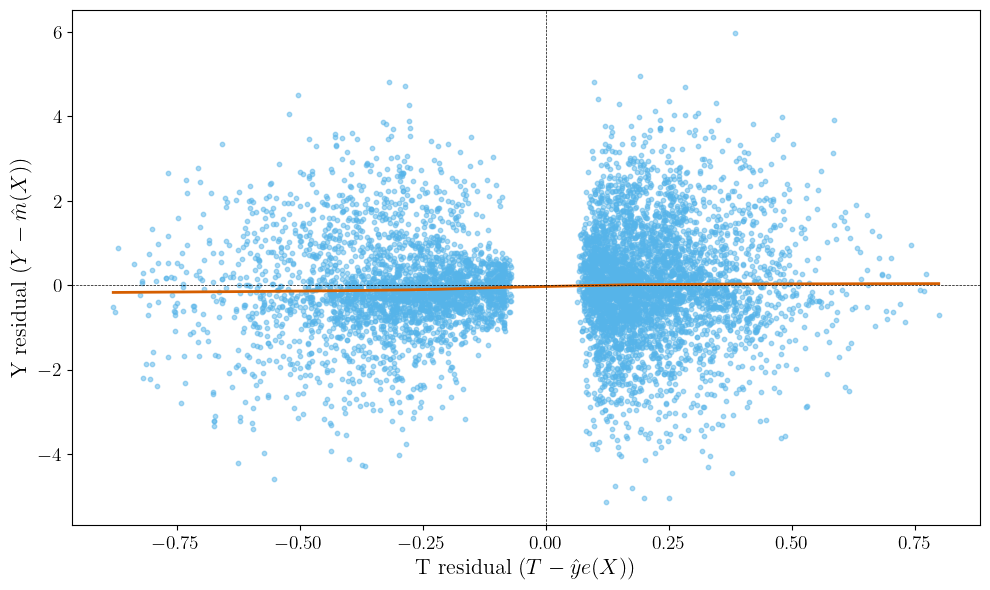

In [87]:
# Residual independence test (see Chernozhukov et al., 2018), Fig. A.5
m_Y = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=18)
m_T = RandomForestClassifier(n_estimators=300, min_samples_leaf=5, random_state=18)
cv = KFold(n_splits=5, shuffle=True, random_state=18)
m_hat = cross_val_predict(m_Y, X_trim, Y_trim, cv=cv) # this is E[Y|X]
e_hat = cross_val_predict(m_T, X_trim, T_trim, cv=cv, method="predict_proba")[:, 1] # this is P(T=1|X)

Y_tilde = Y_trim - m_hat
T_tilde = T_trim - e_hat

corr = np.corrcoef(T_tilde, Y_tilde)[0, 1]
n = len(Y_tilde)
t_stat = corr * np.sqrt((n - 2) / (1 - corr**2))
p_val = 2 * stats.t.sf(np.abs(t_stat), df=n - 2)

print(f"Residual T-Y correlation: {corr: .4f}")
print(f"t-stat (n={n}): {t_stat: .2f}")
print(f"p-value: {p_val: .4f}")

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.regplot(x=T_tilde, y=Y_tilde, lowess=True, scatter_kws=dict(alpha=.5, s=10, color=CB_color_cycle[0]), 
            line_kws=dict(color=CB_color_cycle[2], linewidth=2))
plt.xlabel("T residual $(T-\hat{y} e (X))$") 
plt.ylabel("Y residual $(Y-\hat{m}(X))$") 
# plt.title("Residual-independence test")
plt.axhline(0, c='k', ls='--', lw=0.5)
plt.axvline(0, c='k', ls='--', lw=0.5)
plt.tight_layout()
plt.savefig('figures/Methods/residual_independence_test.png', dpi=200, bbox_inches='tight')
plt.show()

In [88]:
# Cleanup: drop any nans in X_trim, Y_trim, T_trim, W_trim
mask = ~X_trim.isna().any(axis=1)
X_trim = X_trim[mask]
Y_trim = Y_trim[mask]
T_trim = T_trim[mask]
W_trim = W_trim[mask]
clusters_trim = clusters_trim[mask]
print(f"Final sample size: {len(X_trim)}")

Final sample size: 7372


Baseline Causal Forest

In [89]:
# clusters provided at beginning
modelY = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, random_state=randomState)
modelT = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, random_state=randomState)

CF_KWARGS = dict(
    model_y = modelY,
    model_t = modelT,
    n_estimators = 300,
    min_samples_leaf = 10,
    max_depth = None,
    random_state = randomState,
    inference = "bootstrap",
    verbose = 0
)

causal_forest = CausalForestDML(**CF_KWARGS)

causal_forest.fit(
    Y=Y_trim.values, 
    T=T_trim.values, 
    X=X_trim.values, 
    W=W_trim.values,
    groups=clusters_trim,
)

cate_preds = causal_forest.effect(X_trim.values)
lb, ub = causal_forest.effect_interval(X_trim.values, alpha=0.05) 

Coarse grid search

In [131]:
# only for appendix, Table A.2
param_grid = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [5, 10, 20],
    'max_depth': [None, 5, 10],
}

results = []
for params in ParameterGrid(param_grid):
    modelY = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, 
        random_state=randomState)
    modelT = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, 
        random_state=randomState)
    
    cf = CausalForestDML(
        model_y=modelY,
        model_t=modelT,
        n_estimators=params['n_estimators'],
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],
        random_state=randomState,
        inference='bootstrap',
    )
    cf.fit(Y_trim, T_trim, X=X_trim, W=W_trim, groups=clusters_trim)
    te = cf.effect(X)
    hetero = np.var(te)
    lb, ub = cf.effect_interval(X_trim, alpha=0.05)
    avg_width = np.mean(ub - lb)
    results.append({
        'n_estimators': params['n_estimators'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'heterogeneity': hetero,
        'avg_ci_width': avg_width,
    })
results_df = pd.DataFrame(results)
print(results_df)

# get signal-to-noise ratio (heterogeneity/avg_ci_width)
g = results_df.copy()
g["sn_ratio"] = g["heterogeneity"] / g["avg_ci_width"]
print(g.sort_values("sn_ratio", ascending=False).head(5))

    n_estimators  min_samples_leaf  max_depth  heterogeneity  avg_ci_width
0            100                 5        NaN       0.189063      1.476253
1            300                 5        NaN       0.175378      1.187493
2            100                10        NaN       0.139076      1.027067
3            300                10        NaN       0.133175      0.863882
4            100                20        NaN       0.108047      0.748209
5            300                20        NaN       0.104365      0.652001
6            100                 5        5.0       0.062875      0.499519
7            300                 5        5.0       0.062139      0.453493
8            100                10        5.0       0.063611      0.467830
9            300                10        5.0       0.061715      0.439856
10           100                20        5.0       0.061321      0.437574
11           300                20        5.0       0.060575      0.418154
12           100         

The palette list has more values (9) than needed (3), which may not be intended.


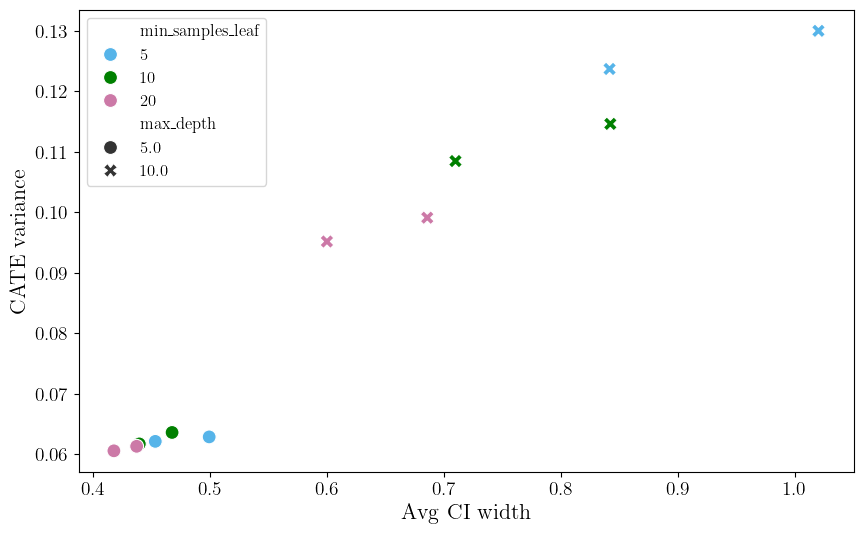

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.scatterplot(data=g, x="avg_ci_width", y="heterogeneity", 
                hue="min_samples_leaf", style="max_depth", 
                palette=CB_color_cycle, s=100)
plt.xlabel("Avg CI width")
plt.ylabel("CATE variance")
# plt.title("Heterogeneity–precision trade-off")
plt.savefig('figures/Methods/heterogeneity_precision_tradeoff.png', dpi=200, bbox_inches='tight')
plt.show()

In [90]:
# Use CF_MAIN from now on
best_params = dict(n_estimators=300, min_samples_leaf=10, max_depth=None) # from grid search
CF_MAIN = CausalForestDML(**CF_KWARGS | best_params).fit(
              Y_trim.values, T_trim.values,
              X=X_trim.values, W=W_trim.values, groups=clusters_trim)

cate_preds = CF_MAIN.effect(X_trim.values)
lb, ub = CF_MAIN.effect_interval(X_trim.values, alpha=0.05) 

In [91]:
plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 22,
    "axes.labelsize": 22,
    "xtick.labelsize":20,
    "ytick.labelsize": 20,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

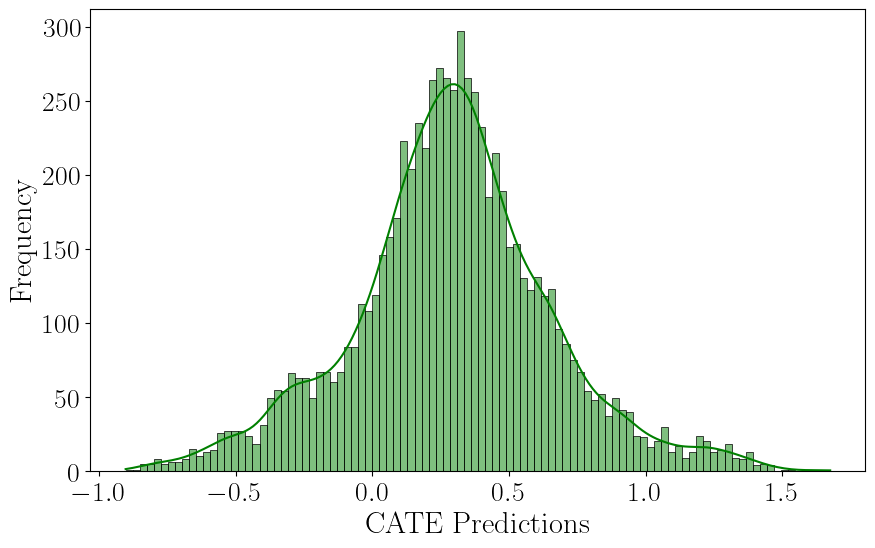

In [92]:
# hist of cate_preds
plt.figure(figsize=(10, 6))
sns.histplot(cate_preds, bins=100, kde=True, color='g')
# plt.title('Histogram of CATE Predictions')
plt.xlabel('CATE Predictions')
plt.ylabel('Frequency')
plt.savefig('figures/Results/histogram_cate_preds.png', dpi=200, bbox_inches='tight')
plt.show()

In [93]:
# evalutation = (pd.to_numeric(cate_preds, errors='coerce').dropna())
skew_val = stats.skew(cate_preds) # currently in log-points!!!
kurt_val = stats.kurtosis(cate_preds)
print(f"Skew: {skew_val:.3f}, Kurtosis (excess): {kurt_val:.3f}")

Skew: 0.066, Kurtosis (excess): 0.681


## Optimization/Calibration

In [67]:
from tqdm.auto import tqdm

cf_base = causal_forest
Xb, Yb, Tb, Gb = X_trim.values, Y_trim.values, T_trim.values, clusters_trim
unique_g = np.unique(Gb)

B = 500  # number of bootstrap samples
rng = np.random.default_rng(randomState)
ate_boot = np.empty(B)
for i in tqdm(range(B), desc="Bootstrapping"):
    draw = rng.choice(unique_g, size=len(unique_g), replace=True)
    mask = np.isin(Gb, draw)
    cf_b = CF_MAIN.fit(Yb[mask], Tb[mask],
        X=Xb[mask], groups=Gb[mask])
    ate_boot[i] = cf_b.ate(Xb[mask])

se_boot = ate_boot.std(ddof=1)
ci_lower, ci_upper = np.percentile(ate_boot, [2.5, 97.5])

ate_base = cf_base.ate(Xb)
lb_base, ub_base = cf_base.ate_interval(Xb)

print(f"Baseline ATE (IJ s.e.): {ate_base:.4f} [{lb_base:.4f}, {ub_base:.4f}]")
print(f"Cluster bootstrap results (B = {B})")
print(f"ATE point estimate: {ate_base:.4f}")
print(f"Bootstrap SE: {se_boot:.4f}")
print(f"95% percentile CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

ate_base_df = pd.DataFrame({
    'ATE': [ate_base],
    'lb': [lb_base],
    'ub': [ub_base],
    'ATE_boot': [ate_boot.mean()],
    'se_boot': [se_boot],
    'ci_lower': [ci_lower],
    'ci_upper': [ci_upper]
})
os.makedirs('data/results', exist_ok=True)
ate_base_df.to_csv('data/results/ate_base.csv', index=False)

Bootstrapping:   0%|          | 0/500 [00:00<?, ?it/s]

Baseline ATE (IJ s.e.): 0.2915 [-0.1714, 0.7545]
Cluster bootstrap results (B = 500)
ATE point estimate: 0.2915
Bootstrap SE: 0.1019
95% percentile CI: [0.1551, 0.5687]


In [ ]:
# if skipped previous step, read in ate_base
ate_base = pd.read_csv('data/results/ate_base.csv', header=0)

In [ ]:
# Permutation placebo test (cluster–constrained permutations)
# whether the forest could have obtained the observed ATE purely from random alignment of T and Y

if not os.path.exists('data/results/perm_test.csv'):
    ate_obs = causal_forest.ate(X_trim.values)
    B   = 500 # number of permutation replications
    rng = np.random.default_rng(18)
    perm_ates = np.empty(B)
    for b in tqdm(range(B), desc="Permutation test", total=B):
        T_perm = (pd.Series(T_trim, index=X_trim.index)
                    .groupby(clusters_trim)
                    .transform(rng.permutation)
                    .values)
        cf_perm = CF_MAIN
        cf_perm.fit(Y_trim.values,
                    T_perm,
                    X=X_trim.values,
                    W=W_trim.values,
                    groups=clusters_trim)
        perm_ates[b] = cf_perm.ate(X_trim.values)
    p_val = (np.abs(perm_ates) >= np.abs(ate_obs)).mean()

    print(f"Observed ATE (baseline data) : {ate_obs: .4f}")
    print(f"Mean placebo ATE : {perm_ates.mean(): .4f}")
    print(f"Two-sided p-value (B={B}) {p_val: .3f}")
    perm_test = pd.DataFrame({
        'ATE_obs': [ate_obs],
        'ATE_perm': [perm_ates.mean()],
        'p_val': [p_val]
    })
    perm_test.to_csv('data/results/perm_test.csv', index=False)

Permutation test: 100%|██████████| 500/500 [47:26<00:00,  5.69s/it]

Observed ATE (baseline data) :  0.2915
Mean placebo ATE :  0.2915
Two-sided p-value (B=500)  1.000


In [ ]:
plt.figure(figsize=(7,4))
plt.hist(perm_ates, bins=30, edgecolor='k', alpha=0.75)
plt.axvline(ate_obs,  color='red', ls='--', lw=2, label='Observed ATE')
plt.axvline(-ate_obs, color='red', ls='--', lw=2)
plt.xlabel("Permutation ATE (log-points)")
plt.ylabel("Frequency")
# plt.title("Permutation placebo distribution of the ATE")
plt.legend() 
plt.tight_layout()
plt.savefig('figures/Results/permutation_placebo.png', dpi=200, bbox_inches='tight')
# plt.show()

In [95]:
# Sensitivity to treatment definition - Table A.4
# robustness to alternative political measures/potential endogeneity

T_house = T_trim.copy()
both_rep = (subset['US Senator 1: Party_Republican'] == 1) & \
           (subset['US Senator 2: Party_Republican'] == 1)
both_rep = both_rep[mask_1]
both_rep = both_rep[mask_2]
both_rep = both_rep[mask_trim]
both_rep = both_rep.reset_index(drop=True)
both_rep = both_rep[mask]
both_rep
T_senate = both_rep.astype(int).values

treatments = {
    "House (Rep=1)": T_house,
    "Senate (both Rep)": T_senate
}

results = []
for name, T_alt in treatments.items():
    cf_alt = CausalForestDML(**CF_KWARGS | best_params)
    cf_alt.fit(Y_trim.values, T_alt, X=X_trim.values, groups=clusters_trim)
    ate = cf_alt.ate(X_trim.values)
    ci_low, ci_high = cf_alt.ate_interval(X_trim.values)

    results.append({
        "Treatment": name,
        "ATE": ate,
        "CI_low": ci_low,
        "CI_high": ci_high
    })
sens_df = (pd.DataFrame(results).assign(ATE_fmt = lambda d:
                     d.apply(lambda r: f"{r['ATE']:.4f} "
                                        f"[{r['CI_low']:.4f}, {r['CI_high']:.4f}]", axis=1)))
print("\nsensitivity of average treatment effect to coding choice")
print(sens_df[['Treatment', 'ATE_fmt']].to_string(index=False))



sensitivity of average treatment effect to coding choice
        Treatment                  ATE_fmt
    House (Rep=1) 0.2485 [-0.2353, 0.7323]
Senate (both Rep) 0.3090 [-0.5862, 1.2042]


Calibration test

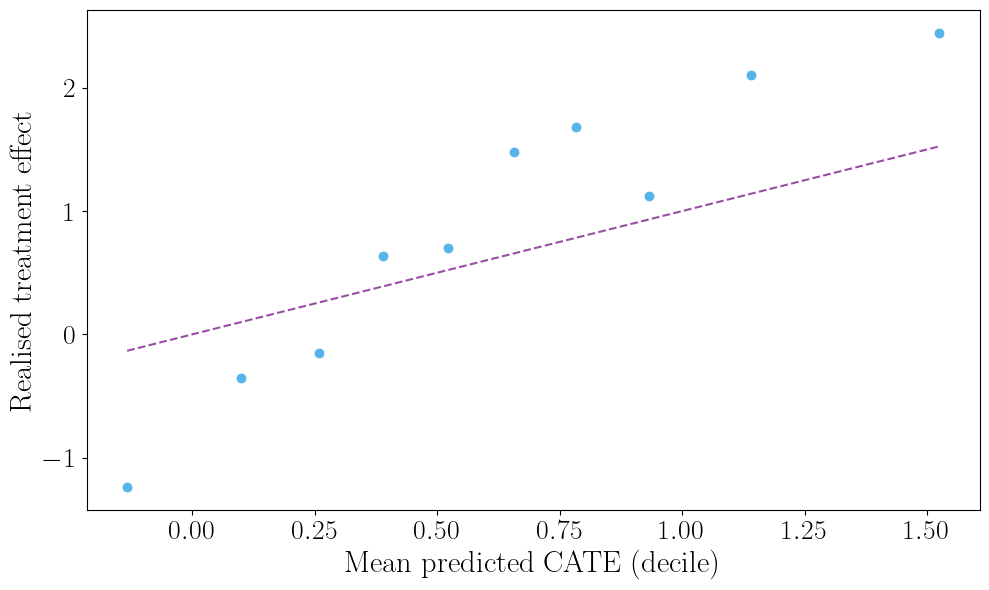

Correlation predicted vs realised across deciles: 0.950


In [97]:
# Causal forest calibration plot, Fig. A.10
X_tr, X_te, Y_tr, Y_te, T_tr, T_te, cl_tr, cl_te = train_test_split(
        X_trim.values, Y_trim.values, T_trim.values, clusters_trim,
        test_size=0.5, stratify=T_trim, random_state=18)

cf_cal = CausalForestDML(**CF_KWARGS | best_params)
cf_cal.fit(Y_tr, T_tr, X=X_tr, groups=cl_tr)
tau_hat = cf_cal.effect(X_te)
df_cal = pd.DataFrame({
        "tau_hat": tau_hat,
        "Y" : Y_te,
        "T" : T_te
})
df_cal["decile"] = pd.qcut(df_cal["tau_hat"], 10, labels=False, duplicates="drop")

# realized vs predicted per decile
mean_Y = (df_cal.groupby(["decile", "T"])["Y"].mean().unstack())
realised  = mean_Y[True] - mean_Y[False]
predicted = df_cal.groupby("decile")["tau_hat"].mean()

plt.figure(figsize=(10,6))
sns.scatterplot(x=predicted, y=realised, s=60, color=CB_color_cycle[0])
plt.plot([predicted.min(), predicted.max()], 
         [predicted.min(), predicted.max()], ls="--", color=CB_color_cycle[4])
plt.xlabel("Mean predicted CATE (decile)")
plt.ylabel("Realised treatment effect")
# plt.title("Causal-forest calibration plot")
plt.tight_layout()
plt.savefig('figures/Results/calibration_plot.png', dpi=200, bbox_inches='tight')
plt.show()

corr = np.corrcoef(predicted, realised)[0, 1]
print(f"Correlation predicted vs realised across deciles: {corr:.3f}")


# Results

In [98]:
if isinstance(X_trim, pd.DataFrame):
    df_res = X_trim.copy()
else:
    feature_names = [f"x{i}" for i in range(X_trim.shape[1])]
    df_res = pd.DataFrame(X_trim, columns=feature_names)

df_res['Y'] = Y_trim
df_res['T'] = T_trim
df_res['cate'] = cate_preds
df_res['ci_low'] = lb
df_res['ci_high'] = ub
ate = df_res['cate'].mean()
std_cate = df_res['cate'].std()
frac_pos = (df_res['cate'] > 0).mean()
print(f"ATE ≈ {ate:.3f}")
print(f"std(CATE) ≈ {std_cate:.3f}")
print(f"% of units with CATE>0: {100*frac_pos:.1f}%")
sig_pos = (df_res['ci_low']  > 0).mean()
sig_neg = (df_res['ci_high'] < 0).mean()
print(f"% significantly positive (CI above zero): {100*sig_pos:.1f}%")
print(f"% significantly negative (CI below zero): {100*sig_neg:.1f}%")

ATE ≈ 0.292
std(CATE) ≈ 0.366
% of units with CATE>0: 82.0%
% significantly positive (CI above zero): 37.2%
% significantly negative (CI below zero): 4.0%


In [99]:
CB_color_cycle = [ # colorblind friendly colors but pretty
    '#56B4E9', '#CC79A7', '#D55E00', 
    '#009E73', '#984ea3', '#999999', 
    '#e41a1c', '#dede00']

tech_colors = { # taken from PyPSA https://pypsa.readthedocs.io/en/latest/_static/pypsa_colors.html
    'Solar':                 '#FFD700',  # golden yellow
    'Wind':                  '#1E90FF',  # dodger blue
    'Storage':               '#FF8C00',  # dark orange
    'Other':                 '#A9A9A9',  # neutral gray
    'Batteries':             '#8A2BE2',  # blue‑violet
    'Cement':                '#696969',  # dim gray
    'Critical Minerals':     '#228B22',  # forest green
    'Fueling Equipment':     '#FF4500',  # orange‑red
    'Zero Emission Vehicles':'#32CD32',  # lime green
    'Carbon Management':     '#006400',  # dark green
    'Hydrogen':              '#00CED1',  # dark turquoise
    'SAF':                   '#FF6347',  # tomato (warm red)
    'Clean Fuels':           '#7CFC00',  # lawn green
    'Electrolyzers':         '#40E0D0',  # turquoise
    'Nuclear':               '#9400D3',  # dark violet
    'Iron & Steel':          '#B22222',  # firebrick (rust/red)
    'Pulp & Paper':          '#DEB887',  # burlywood (light brown)
}

plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The palette list has more values (8) than needed (4), which may not be intended.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The palette list has more values (8) than needed (4), which may not be intended.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The palette list has more values (8) than needed (4), which may not be intended.
The default of observed=False is deprecated and will be changed to True in a future version of

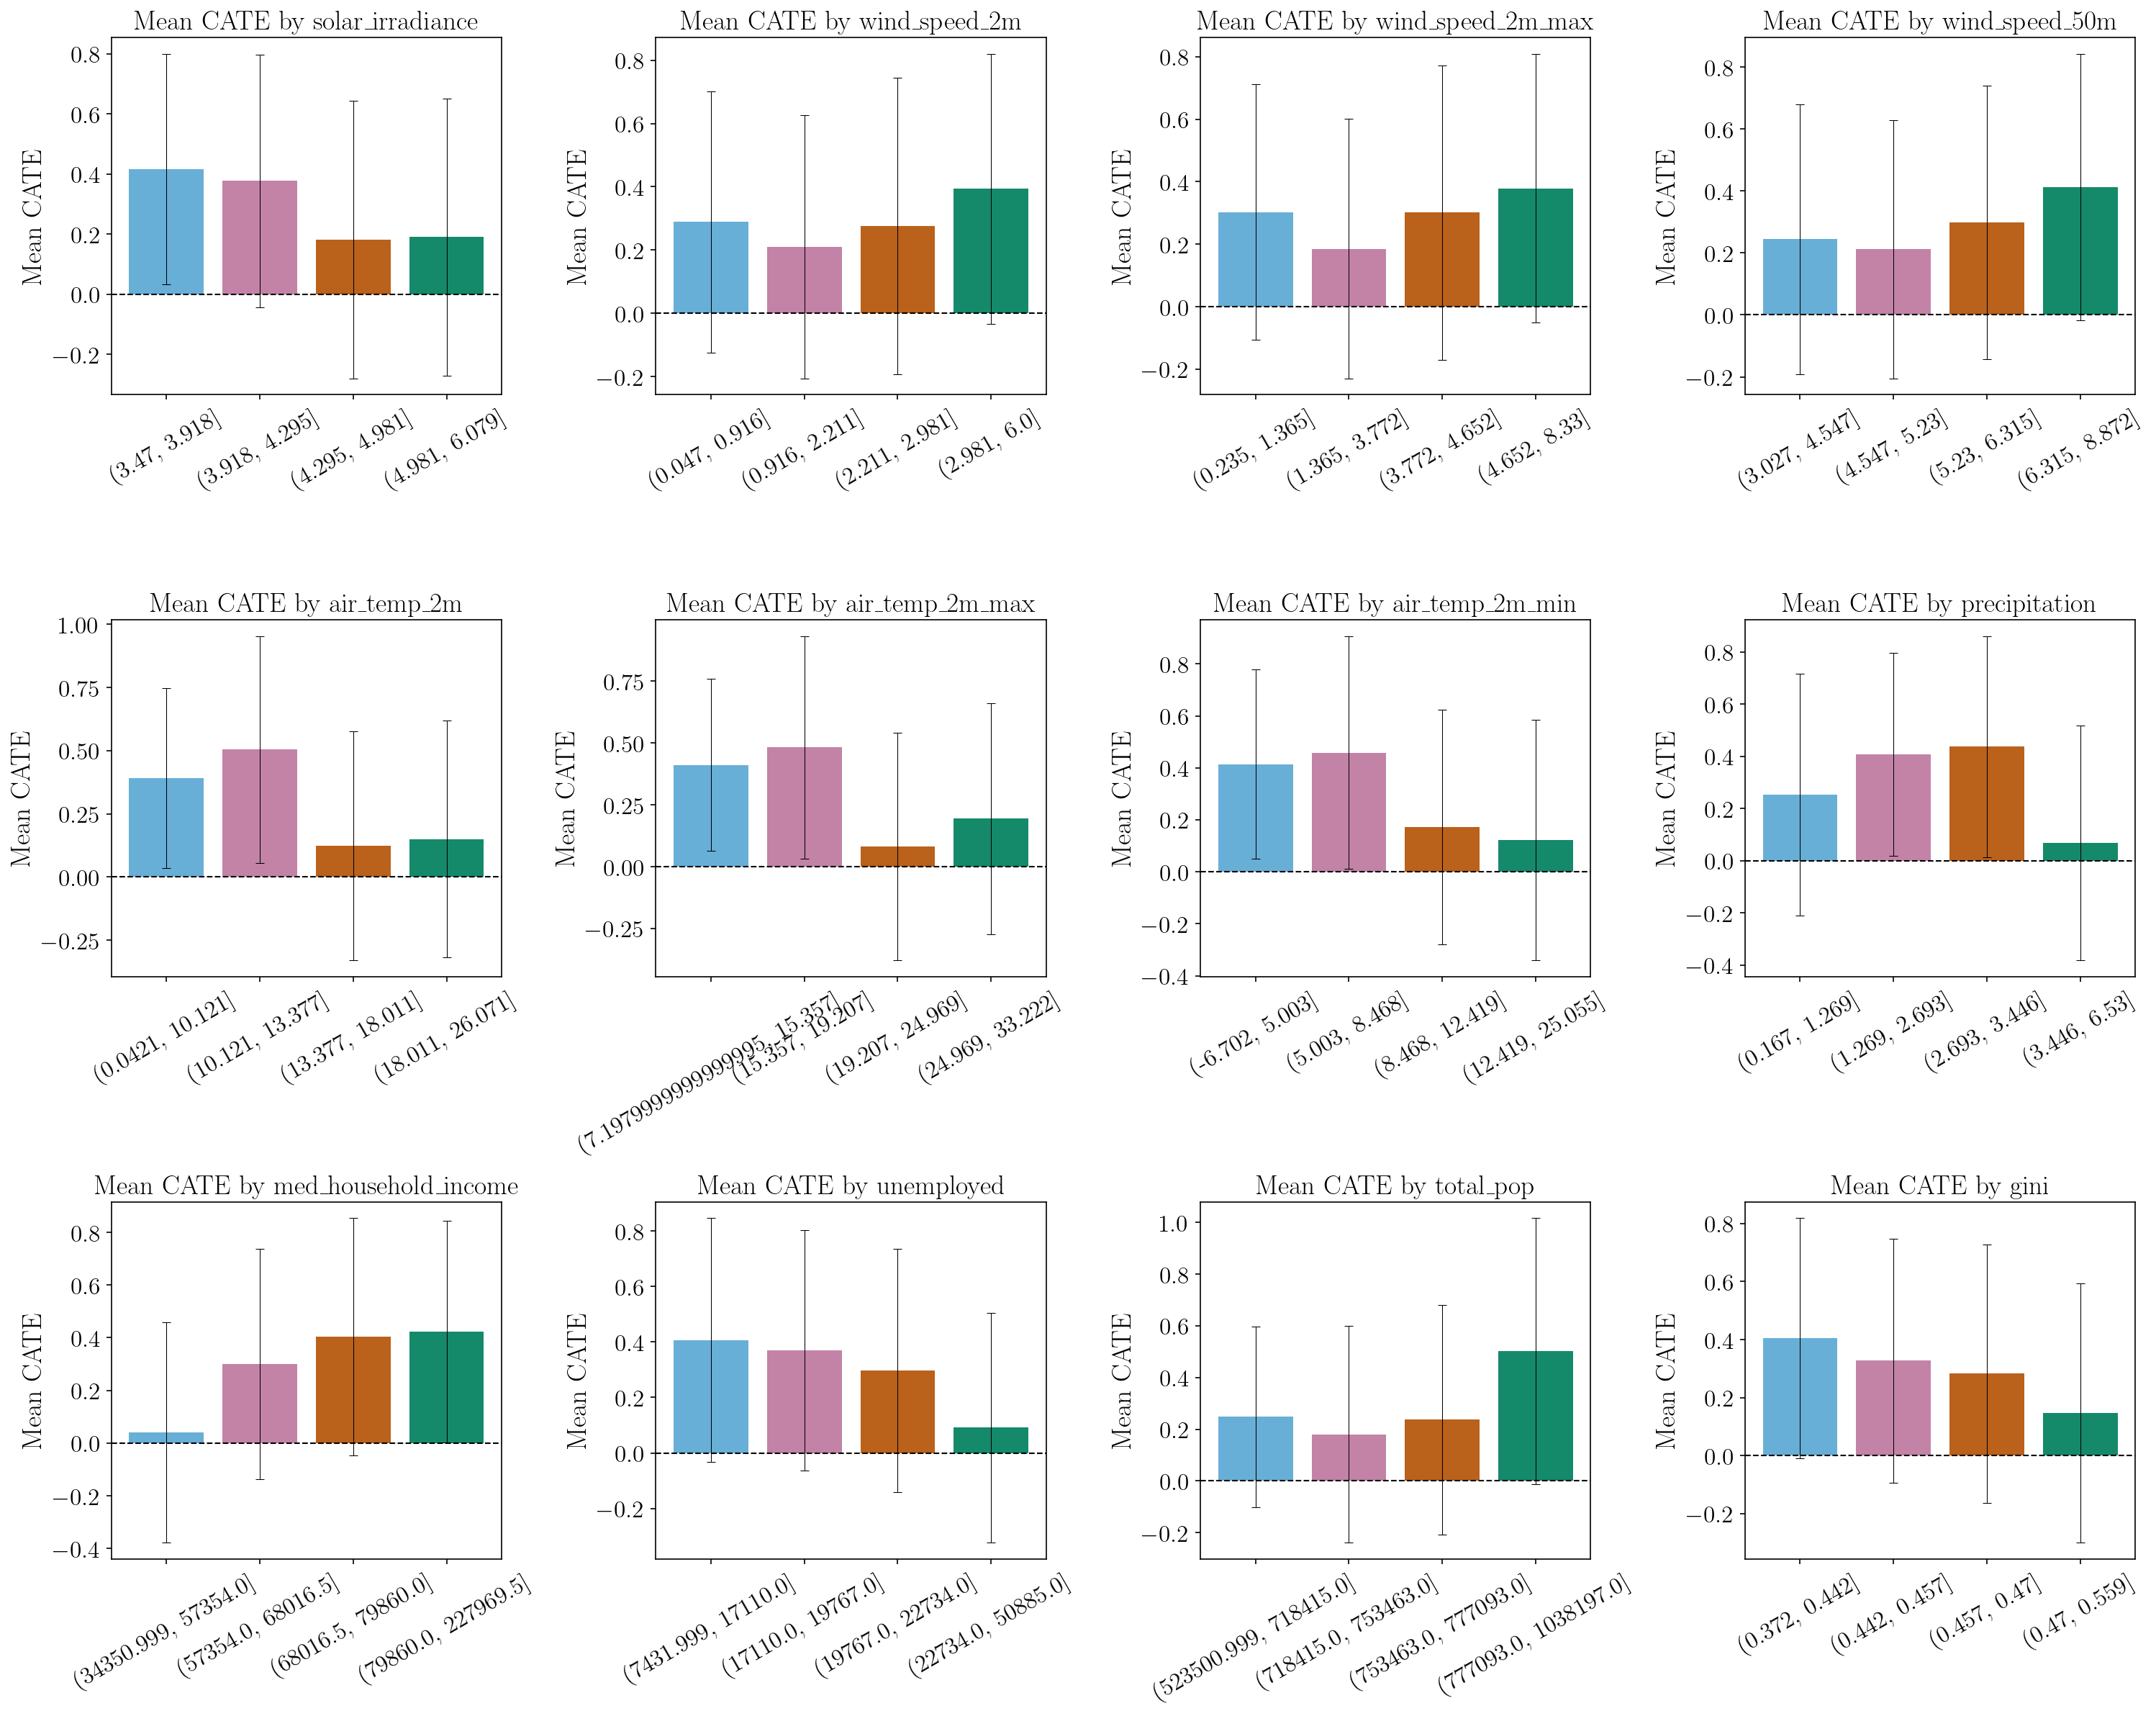

In [100]:
# Fig A.6: CATE by numeric covariate
fig, axes = plt.subplots(3, 4, figsize=(20, 16), dpi=150)
for ax, cov in zip(axes.flatten(), X_num.columns):
    if cov not in df_res.columns:
        continue
    uniq = df_res[cov].unique()
    if len(uniq) > 4:
        bins = pd.qcut(df_res[cov], 4)
    else:
        bins = df_res[cov]
    sub = (df_res.assign(_bin=bins).groupby('_bin')[['cate','ci_low','ci_high']].mean().reset_index())
    sub['_bin_str'] = sub['_bin'].astype(str)
    sns.barplot(data=sub, x='_bin_str', y='cate', ax=ax, palette=CB_color_cycle , hue='_bin_str', legend=False)
    errs = [sub['cate'] - sub['ci_low'], sub['ci_high'] - sub['cate']]
    ax.errorbar(x=np.arange(len(sub)), y=sub['cate'], yerr=errs, fmt='none', ecolor='black', capsize=3, color="black", capthick=0.5, linewidth=0.5)
    ax.set_title(f"Mean CATE by {cov}")
    ax.set_ylabel("Mean CATE")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.savefig('figures/Results/cate_by_numeric_covariate.png', dpi=200)
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



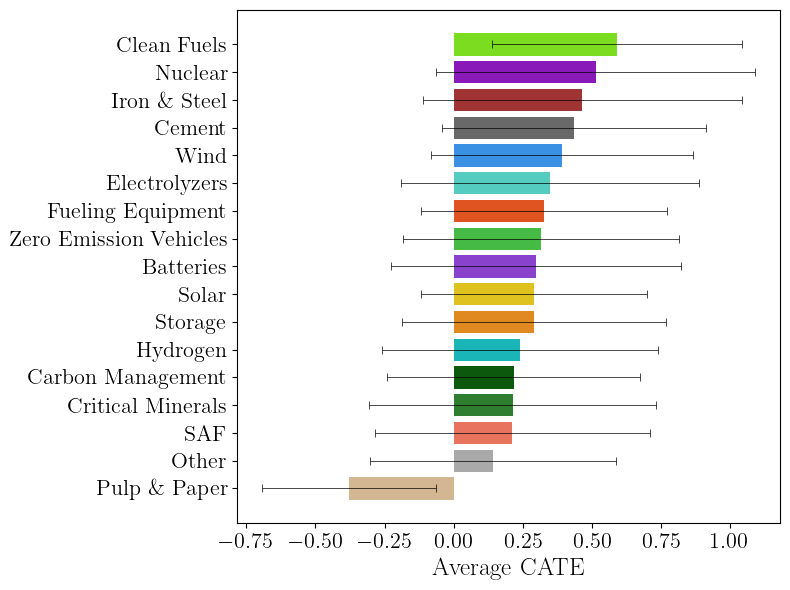

In [101]:
results = []
tech_cols = [col for col in X.columns if 'technology' in col.lower()]
for i, row in df_res.iterrows():
    for col in tech_cols:
        if row[col] == 1:
            results.append({
                'cate': row['cate'],
                'ci_low': row['ci_low'],
                'ci_high': row['ci_high'],
                'technology': col,
            })
results_df = pd.DataFrame(results)
results_df['technology'] = results_df['technology'].str.split('_').str[1]

# CATE by technology
tech_cate = results_df.groupby('technology')[['cate', 'ci_low', 'ci_high']].mean()
tech_cate = tech_cate.reset_index()
tech_cate = tech_cate.rename(columns={'cate': 'avg_cate'})
tech_cate = tech_cate.sort_values(by='avg_cate', ascending=False)

tech_cols_plane = tech_cate['technology']
tech_colors_list = []
for tech in tech_cols_plane:
    if tech in tech_colors:
        tech_colors_list.append(tech_colors[tech])
    else:
        raise ValueError(f"Technology {tech} not found in tech_colors dictionary")
tech_cate['technology'] = tech_cate['technology'].str.replace('&', '\\&', regex=False)

plt.figure(figsize=(8, 6))
sns.barplot(y='technology', x='avg_cate', data=tech_cate, palette=tech_colors_list)
plt.errorbar(y=tech_cate['technology'], x=tech_cate['avg_cate'], 
             xerr=[tech_cate['avg_cate'] - tech_cate['ci_low'], tech_cate['ci_high'] - tech_cate['avg_cate']], 
             fmt='none', capsize=3, color="black", capthick=0.5, linewidth=0.5)
plt.xlabel('Average CATE')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/Results/cate_by_technology.png', dpi=200, bbox_inches='tight')
plt.show()

In [102]:
# Result summary and economic implications
capex_raw = subset.loc[X_trim.index, 'log_Estimated_Total_Facility_CAPEX'] 
capex_raw = np.exp(capex_raw) - 1 # transform back, now in million USD 2023
bench_capex = capex_raw.mean() # more robust
ate_log  = causal_forest.ate(X_trim.values)
ate_pct  = np.expm1(ate_log) * 100
ate_usd  = np.expm1(ate_log) * bench_capex
df_res['CATE_pct'] = np.expm1(df_res['cate']) * 100
df_res['CATE_usd'] = np.expm1(df_res['cate']) * bench_capex

print(f"ATE = {ate_log:.4f} log-pts -> {ate_pct:.1f}% "
      f"(~ ${ate_usd:.2f} million on a ${bench_capex:.2f} million bench project)")
print(df_res[['CATE_pct', 'CATE_usd']].describe(percentiles=[.1,.25,.5,.75,.9]))

ATE = 0.2915 log-pts -> 33.8% (~ $41.38 million on a $122.24 million bench project)
          CATE_pct     CATE_usd
count  7372.000000  7372.000000
mean     43.275138    52.900907
std      56.398488    68.943309
min     -59.451356   -72.675231
10%     -16.602798   -20.295790
25%       9.483033    11.592362
50%      34.037175    41.608127
75%      64.283651    78.582383
90%     107.738117   131.702507
max     434.357731   530.972732


#### Validation

In [28]:
# import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
mse_scores = []
r2_scores  = []
all_folds  = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_trim, T_trim)):
    X_train, X_test = X_trim.iloc[train_idx], X_trim.iloc[test_idx]
    T_train, T_test = T_trim.iloc[train_idx], T_trim.iloc[test_idx]
    model = RandomForestRegressor(random_state=18)
    model.fit(X_train, T_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(T_test, preds)
    r2  = r2_score(T_test, preds)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold_idx+1} — Test size: {len(test_idx)}  |  MSE: {mse:.3f}  |  R²: {r2:.3f}")
    df_fold = X_test.copy()
    df_fold['T_true']   = T_test.values
    df_fold['T_pred']   = preds
    df_fold['fold']     = fold_idx + 1
    all_folds.append(df_fold)

results_df = pd.concat(all_folds, ignore_index=True)

print("\nOverall CV performance:")
print(f" → Mean MSE: {np.mean(mse_scores):.3f}  ± {np.std(mse_scores):.3f}")
print(f" → Mean R² : {np.mean(r2_scores):.3f}  ± {np.std(r2_scores):.3f}")

Fold 1 — Test size: 1475  |  MSE: 0.020  |  R²: 0.919
Fold 2 — Test size: 1475  |  MSE: 0.017  |  R²: 0.930
Fold 3 — Test size: 1474  |  MSE: 0.019  |  R²: 0.922
Fold 4 — Test size: 1474  |  MSE: 0.021  |  R²: 0.914
Fold 5 — Test size: 1474  |  MSE: 0.022  |  R²: 0.910

Overall CV performance:
 → Mean MSE: 0.020  ± 0.002
 → Mean R² : 0.919  ± 0.007




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has more values (9) than needed (5), which may not be intended.


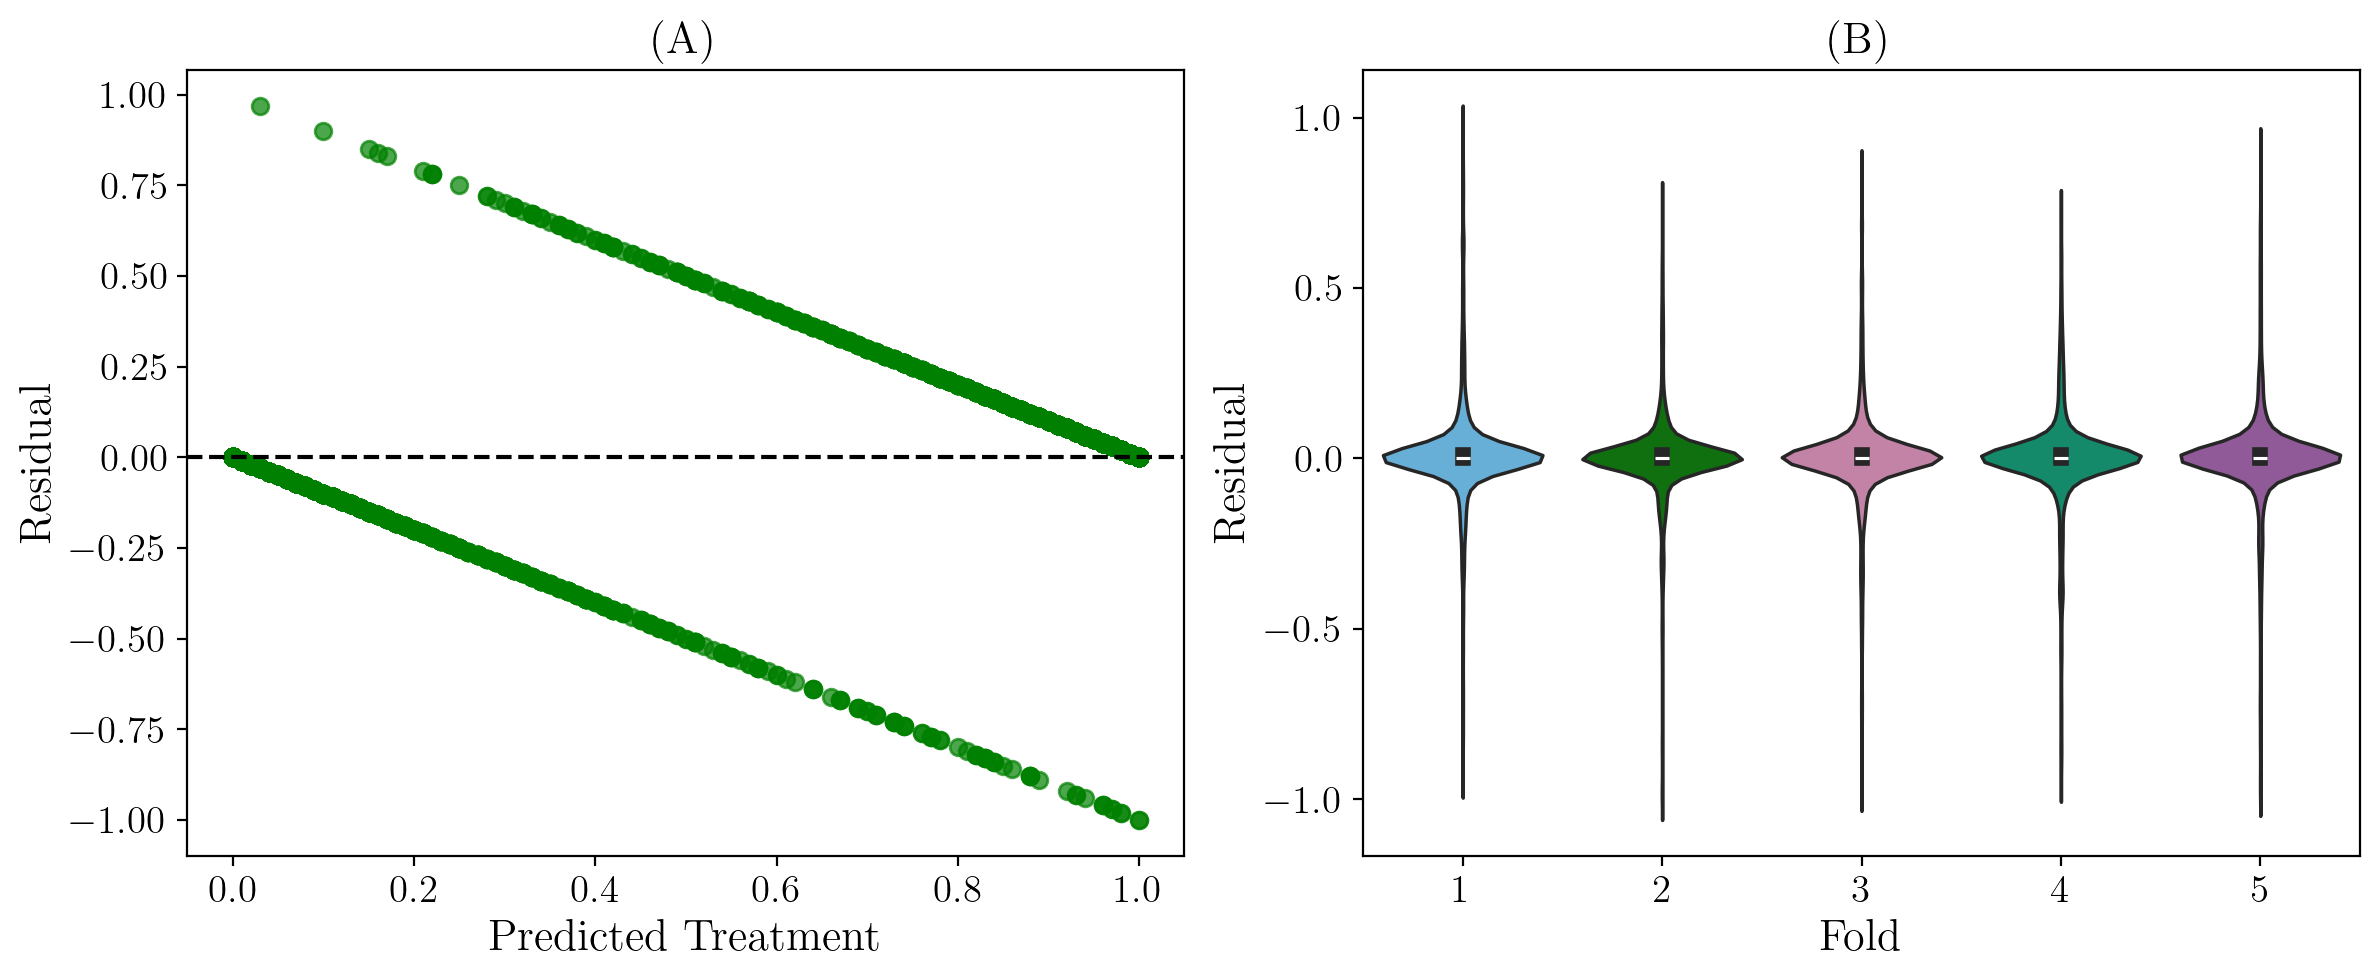

In [39]:
# plot the two figures next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
axes[0].scatter(results_df['T_pred'],  # figure A.12
            results_df['T_true'] - results_df['T_pred'], 
            alpha=0.7, color='green')
axes[0].axhline(0, linestyle='--', color='k')
axes[0].set_xlabel("Predicted Treatment")
axes[0].set_ylabel("Residual")
axes[0].set_title("(A)")  
sns.violinplot(x='fold', y=results_df['T_true'] - results_df['T_pred'], data=results_df, ax=axes[1], palette=CB_color_cycle)
axes[1].set_title("(B)")
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Residual")
plt.tight_layout()
plt.savefig('figures/Methods/cv_residuals.png', dpi=200, bbox_inches='tight')
plt.show()

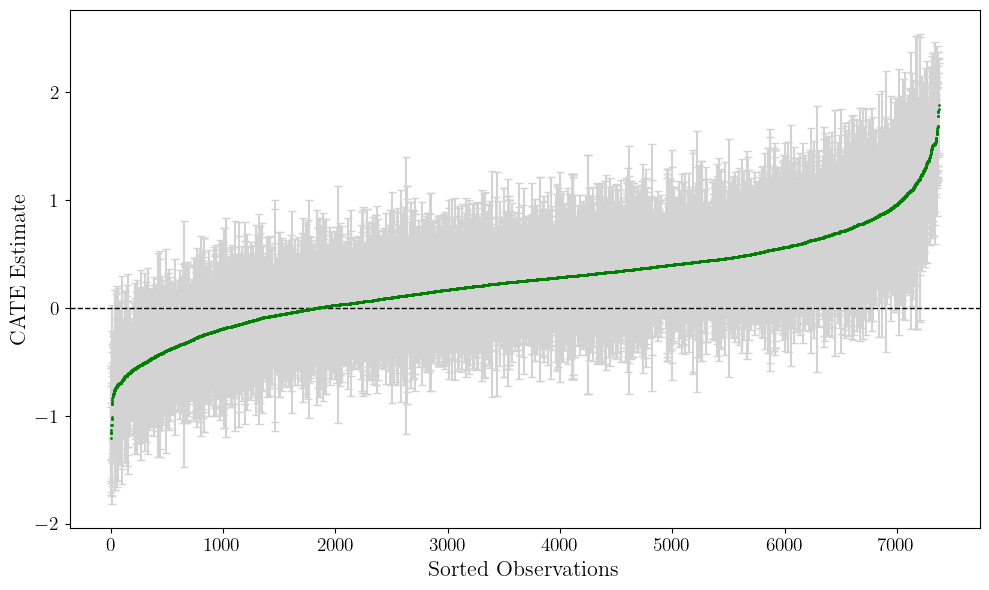

In [37]:
# Fig. A.12 for heterogeneity
sorted_idx = np.argsort(cate_preds)
sorted_cate = cate_preds[sorted_idx]
sorted_lb = lb[sorted_idx]
sorted_ub = ub[sorted_idx]

plt.figure(figsize=(10, 6))
plt.errorbar(
    range(len(sorted_cate)),
    sorted_cate,
    yerr=[abs(sorted_cate - sorted_lb), abs(sorted_ub - sorted_cate)],
    fmt='o',
    markersize=1,
    color='green',
    ecolor='lightgray',
    capsize=3,
)
# plt.title('Sorted CATE Estimates with 95% Confidence Intervals', fontsize=14)
plt.xlabel('Sorted Observations', fontsize=16)
plt.ylabel('CATE Estimate', fontsize=16)
plt.tight_layout()
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.savefig('figures/Results/sorted_cate_estimates.png', dpi=200, bbox_inches='tight')
plt.show()

In [90]:
# Diff in diff (discussion), Appendix
from linearmodels.panel import PanelOLS

ctrl_cols = [ # include those that vary within district over time 
    'solar_irradiance', 'wind_speed_2m', 'precipitation',
    'med_household_income', 'unemployed', 'total_pop', 'gini']
df_panel = (pd.concat({'Y' : Y_trim, 'T' : T_trim, **{c: X_trim[c] for c in ctrl_cols}}, axis=1)
    .assign(district = clusters_trim, year = W_trim.filter(like='Announcement_Year').idxmax(axis=1)
                       .str.split('_').str[-1].astype(int))
    .groupby(['district', 'year']).agg({'Y' : 'mean', 'T' : 'first', **{c: 'mean' for c in ctrl_cols}})
    .reset_index().set_index(['district', 'year']))
formula = "Y ~ T + " + " + ".join(ctrl_cols) + " + EntityEffects + TimeEffects"
mod = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.0137
Estimator:                   PanelOLS   R-squared (Between):              0.2021
No. Observations:                1918   R-squared (Within):               0.0025
Date:                Tue, Apr 29 2025   R-squared (Overall):              0.1971
Time:                        17:15:32   Log-likelihood                   -2912.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.9873
Entities:                         396   P-value                           0.0041
Avg Obs:                       4.8434   Distribution:                  F(7,1506)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             1.8204
                            


Variables have been fully absorbed and have removed from the regression:

T



  0%|          | 0/100 [00:00<?, ?it/s]

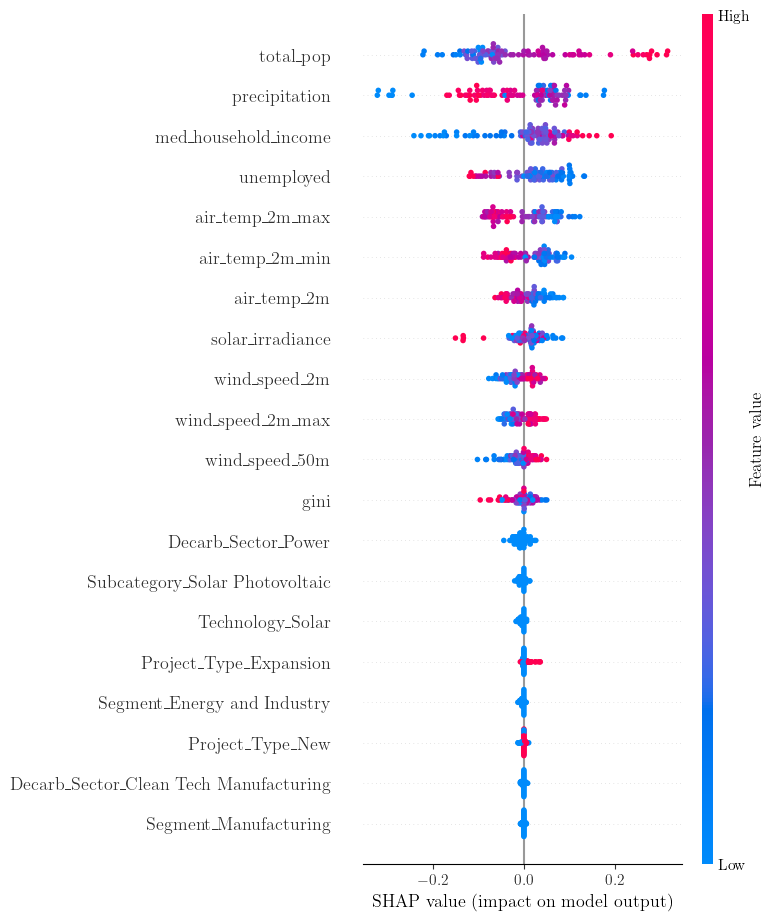

In [ ]:
# not used in paper
np.random.seed(randomState)
background = X.values[np.random.choice(X.shape[0], size=50, replace=False)]
def cate_predict(x):
    return causal_forest.effect(x)

explainer = shap.KernelExplainer(cate_predict, background)
X_subset = X.values[:100]
shap_values = explainer.shap_values(X_subset)
shap.summary_plot(shap_values, X_subset, feature_names=X.columns)